

<br>
<br>


<h1><center> SFS </center></h1>


<br>
<br>


#### Signal Formation Simulation
The idea is to develop a lightweight and easy-to-use tool for the top-down how affects the performance of the next-generation dark matter detector.
The code is based on the Noble Element Simulation Technique (NEST).


<br>
<br>


#### This Notebook
This is the notebook that was used to actually conduct the study.
It is supposed to further serve as documentation of the ''sfs.py'' library. Feel free to copy the exemplary function calls below into your personal study project.


<br>
<br>


#### Contents


1. **[Setup](#Setup)**
2. **[Imports and Definitions](#Imports-and-Definitions)**
3. **[Detector Definition](#Detector-Definition)**
4. **[Spectra Definition](#Spectra-Definition)**
5. **[Executing NEST](#Executing-NEST)**
6. **[ER/NR Discrimination](#ER/NR-Discrimination)**
7. **[Maximum Likelihood Sensitivity Estimation](#Maximum-Likelihood-Sensitivity-Estimation)**


<br>
<br>


#### Credits
- NEST collaboration
- C. Hock


<br>
<br>



<br>
<br>


# Setup


<br>
<br>


- install NEST following their official documentation


- Store the absolute path of the NEST installation, i.e., the directory containing the `nest`, `install`, and `build` directories, in an environmental variable. Therefore execute:<br> `$ echo 'export ABSPATH_NEST_INSTALLATION="/abspath/to/your/nest/root/directory/" >> ~/.bashrc'`


- git clone the ''sfsv2'' repository


- edit the ''sfs.py'' file


<br>
<br>



<br>
<br>


# Imports and Definitions


<br>
<br>


#### paths

In [1]:


# path definitions
abspath_sfs_repo = "/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/"
abspath_study = abspath_sfs_repo # you'll probably have different paths for 'abspath_sfs_repo' and 'abspath_study'
abspath_detectors = abspath_study +"detectors/"
abspath_spectra = abspath_study +"spectra/"
abspath_resources = abspath_study +"resources/"
abspath_list_plots = [abspath_study +"plots/", "/home/daniel/Desktop/arbeitsstuff/thesis/images/sfs/"]
abspath_signatures = abspath_study +"signatures/"
abspath_discrimination_lines = abspath_study +"discrimination_lines/"
abspath_test = abspath_study +"test/"
abspath_er_leakage_study = abspath_study +"20230519__er_leakage_study/"


#### imports

In [2]:

# imports <---- check which one of those are actually needed
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import time
from datetime import timedelta
import datetime
import matplotlib.gridspec as gridspec



# importing my personal matplotlib style file
import matplotlib as mpl
plt.style.use("file:///home/daniel/Desktop/arbeitsstuff/monxe/software/miscfig/danielsmplstyle.mplstyle")


# importing the sfs library
import sys
sys.path.append(abspath_sfs_repo)
import sfs


#### study assumptions

In [3]:


# default study parameters
default_wimp_eroi_kev_ee = [1.4, 11.6] # WIMP energy region of interest in keV_ee
default_wimp_eroi_kev_nr = [sfs.convert_recoil_energy_scale(default_wimp_eroi_kev_ee[0], "ER"), sfs.convert_recoil_energy_scale(default_wimp_eroi_kev_ee[1], "ER")] # WIMP energy region of interest in keV_nr
print(f"WIMP EROI: [{default_wimp_eroi_kev_ee[0]:.1f},{default_wimp_eroi_kev_ee[1]:.1f}] keV_ER")
print(f"WIMP EROI: [{default_wimp_eroi_kev_nr[0]:.1f},{default_wimp_eroi_kev_nr[1]:.1f}] keV_NR")
default_wimp_mass_gev = 100 # WIMP mass in GeV
default_wimp_nucleon_cross_section_cm2 = 5e-49 # WIMP-nucleon cross-section in cm^2


# default study settings
default_number_of_medium_stat_simulations = 5*10**5 # number of events simulated in medium statistics simulations
default_number_of_high_stat_simulations = 5*10**6 # number of events simulated in high statistics simulations
default_simulation_energy_bins = 50 # number of energy bins used for the spectra simulation
default_recoil_energy_simulation_window_er = [0.8*default_wimp_eroi_kev_ee[0], default_wimp_eroi_kev_ee[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
default_recoil_energy_simulation_window_nr = [0.8*default_wimp_eroi_kev_nr[0], default_wimp_eroi_kev_nr[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
print(f"simulation EROI: [{default_recoil_energy_simulation_window_er[0]:.1f},{default_recoil_energy_simulation_window_er[1]:.1f}] keV_ER")
print(f"simulation EROI: [{default_recoil_energy_simulation_window_nr[0]:.1f},{default_recoil_energy_simulation_window_nr[1]:.1f}] keV_NR")
default_number_of_discrimination_line_energy_bins = 50 # number of energy bins into which the WIMP EROI is subdivided for the computation of the ER rejection
default_nr_acceptance = 0.50 # acceptance of the (not in percent) of the nuclear recoils on which the NR computation is based
default_seed_for_baseline_assessment = 2615 # 2614


# default detector parameters
default_param_range_eLife_us = [800, 19200] # in us, baseline value: 10000 us
default_param_range_e_drift = [80, 320] # in V/cm, baseline value: 200 V/cm
default_param_range_g1 = [0.080, 0.170] # in phd/photon, baseline value: 0.125
default_param_range_E_gas = [6.0, 10.0] # in kV/cm, baseline value: 8 kV/cm
default_param_eLife_us = 10000
default_param_e_drift = 200
default_param_g1 = 0.125
default_param_E_gas = 8


WIMP EROI: [1.4,11.6] keV_ER
WIMP EROI: [7.3,54.9] keV_NR
simulation EROI: [1.1,17.4] keV_ER
simulation EROI: [5.9,82.3] keV_NR



<br>
<br>


# DARWIN Baseline Detector Definition


<br>
<br>


In [4]:


# defining the 'detector_dict'
darwin_baseline_detector_dict = {
    # primary scintillation (S1) parameters
    "g1"                : default_param_g1,         # phd per S1 phot at dtCntr (not phe), divide out 2-PE effect,                          JN: 0.119, LUX_Run03: 0.1170 (0.117+/-0.003 WS,0.115+/-0.005 D-D,0.115+/-0.005 CH3T,0.119+/-0.001 LUXSim), XENON10: 0.073
    "sPEres"            : 0.35,                     # single phe (=PE=photoelectrons) resolution (Gaussian assumed),                        JN: 0.38, LUX_Run03: 0.37 (arXiv:1910.04211.), XENON10: 0.58
    "sPEthr"            : 0.35,                     # POD threshold in phe, usually used IN PLACE of sPEeff,                                JN: 0.35, LUX_Run03: (0.3 * 1.173) / 0.915 (arXiv:1910.04211.), XENON10: 0.35
    "sPEeff"            : 1.0,                      # actual efficiency, can be used in lieu of POD threshold, units: fractional,           JN: 0.90, LUX_Run03: 1.00 (arXiv:1910.04211), XENON10: 1.00
    "noiseBaseline[0]"  : 0.0,                      # baseline noise mean in PE (Gaussian),                                                 JN: 0.0, LUX_Run03: 0.00 (arXiv:1910.04211 says -0.01), XENON10: 0.0
    "noiseBaseline[1]"  : 0.0,                      # baseline noise width in PE (Gaussian),                                                JN: 0.0, LUX_Run03: 0.08 (arXiv:1910.04211), XENON10: 0.0
    "noiseBaseline[2]"  : 0.0,                      # baseline noise mean in e- (for grid wires),                                           JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "noiseBaseline[3]"  : 0.0,                      # baseline noise width in e- (for grid wires),                                          JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "P_dphe"            : 0.2,                      # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT, units: fractional,         JN: 0.22, LUX_Run03: 0.173 (arXiv:1910.04211), XENON10: 0.2
    "coinWind"          : 150,                      # S1 coincidence window in ns,                                                          JN: 100, LUX_Run03: 100 (1310.8214), XENON10: 100
    "coinLevel"         : 3,                        # how many PMTs have to fire for an S1 to count,                                        JN: 3, LUX_Run03: 2 (1512.03506), XENON10: 2
    "numPMTs"           : 494,                      # for coincidence calculation,                                                          JN: 494, LUX_Run03: 119 (122 minus 3 off), XENON10: 89
    "OldW13eV"          : "true",                   # default true, which means use "classic" W instead of Baudis / EXO's,                  JN: none, LUX_Run03: "true", XENON10: "true"
    "noiseLinear[0]"    : 0.0e-2,                   # S1->S1 Gaussian-smeared with noiseL[0]*S1, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    "noiseLinear[1]"    : 0.0e-2,                   # S2->S2 Gaussian-smeared with noiseL[1]*S2, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    # ionization and secondary scintillation (S2) parameters
    "g1_gas"            : 0.125,                    # phd per S2 photon in gas, used to get SE size, units: phd per e-,                     JN: 0.102, LUX_Run03: 0.1 (0.1 in 1910.04211), XENON10: 0.0655
    "s2Fano"            : 2.0,                      # Fano-like fudge factor for SE width, dimensionless,                                   JN: 3.61, LUX_Run03: 3.6 (3.7 in 1910.04211; this matches 1608.05381 better), XENON10: 3.61
    "s2_thr"            : 10.0,                     # the S2 threshold in phe or PE, *not* phd. Affects NR most,                            JN: 100.0, LUX_Run03: (150.0 * 1.173) / 0.915 (65-194 pe in 1608.05381), XENON10: 300.0
    "E_gas"             : default_param_E_gas,      # field in kV/cm between liquid/gas border and anode,                                   JN: 10.85, LUX_Run03: 6.25 (6.55 in 1910.04211), XENON10: 12.0
    "eLife_us"          : default_param_eLife_us,   # the drift electron mean lifetime in micro-seconds,                                    JN: 1600.0, LUX_Run03: 800.0 (p.44 of James Verbus PhD thesis Brown), XENON10: 2200.0
    # thermodynamic properties
#    "inGas"             : "false",                  # (duh),                                                                               JN: "false", LUX_Run03: commented out, XENON10: "false"
    "T_Kelvin"          : 175.0,                    # for liquid drift speed calculation, temperature in Kelvin,                            JN: 175.0, LUX_Run03: 173.0 (1910.04211), XENON10: 177.0
    "p_bar"             : 1.9,                      # gas pressure in units of bars, it controls S2 size,                                   JN: 2.0, LUX_Run03: 1.57 (1910.04211), XENON10: 2.14
    # data analysis parameters and geometry
    "dtCntr"            : 900.0,                    # center of detector for S1 corrections, in usec.,                                      JN: 822.0, LUX_Run03: 160.0 (p.61 Dobi thesis UMD, 159 in 1708.02566), XENON10: 40.0
    "dt_min"            : 100.0,                    # minimum. Top of detector fiducial volume, units: microseconds,                        JN: 75.8, LUX_Run03: 38.0 (1608.05381), XENON10: 20.0
    "dt_max"            : 1700.0,                   # maximum. Bottom of detector fiducial volume, units: microseconds,                     JN: 1536.5, LUX_Run03: 305.0 (1608.05381), XENON10: 60.0
    "radius"            : 1250.0,                   # millimeters (fiducial rad), units: millimeters,                                       JN: 1300., LUX_Run03: 200.0 (1512.03506), XENON10: 50.0
    "radmax"            : 1300.0,                   # actual physical geo. limit, units: millimeters,                                       JN: 1350., LUX_Run03: 235.0 (1910.04211), XENON10: 50.0
    "TopDrift"          : 2650.0,                   # top of drift volume in mm not cm or us, i.e., this *is* where dt=0, z=0mm is cathode,  JN: 3005.0, LUX_Run03: 544.95 (544.95 in 1910.04211), XENON10: 150.0
    "anode"             : 2657.0,                   # the level of the anode grid-wire plane in mm,                                         JN: 3012.5, LUX_Run03: 549.2 (1910.04211 and 549 in 1708.02566), XENON10: 152.5
    "gate"              : 2643.0,                   # mm. this is where the E-field changes (higher),                                       JN: 3000.0, LUX_Run03: 539.2 (1910.04211 and 539 in 1708.02566), XENON10: 147.5
    "cathode"           : 50.0,                     # mm. defines point below which events are gamma-X                                      JN: 250, LUX_Run03: 55.90 (55.9-56 in 1910.04211,1708.02566), XENON10: 1.00
    # 2D (xy) position reconstruction
    "PosResExp"         : 0.015,                    # exp increase in pos recon res at hi r, units: 1/mm,                                   JN: 0.015, LUX_Run03: 0.015 (arXiv:1710.02752 indirectly), XENON10: 0.015
    "PosResBase"        : 30.,                      # baseline unc in mm, see NEST.cpp for usage,                                           JN: 30.0, LUX_Run03: 70.8364 ((1710.02752 indirectly), XEONON10: 70.8364
}



# non-NEST detector parameters
darwin_baseline_detector_drift_field_v_cm = default_param_e_drift # drift field of the darwin baseline design in V/cm
darwin_baseline_detector_runtime_y = 5 # live time of the experiment in years
darwin_baseline_detector_fiducial_mass_t = 30 # fiducial volume of the detector in metric tonnes


# adjusting drift times according to detector dimension
darwin_baseline_detector_dict = sfs.adjust_detector_drift_time_parameters(darwin_baseline_detector_dict, darwin_baseline_detector_drift_field_v_cm)


# saving the 'detector_dict' of the darwin baseline detector
sfs.write_dict_to_json(abspath_detectors +"example__detector__darwin_baseline_detector.json", darwin_baseline_detector_dict)


# derived parameters
darwin_baseline_detector_g2 = sfs.compute_g2_from_detector_configuration(darwin_baseline_detector_dict)
print(f"g2: {darwin_baseline_detector_g2} phd per primary electron")
darwin_baseline_detector_drift_velocity_mm_usec = sfs.compute_drift_velocity_from_detector_configuration(darwin_baseline_detector_dict,darwin_baseline_detector_drift_field_v_cm)
print(f"drift velocity: {darwin_baseline_detector_drift_velocity_mm_usec} mm/usec")
darwin_baseline_detector_active_xenon_mass_t = sfs.calc_active_xenon_mass_of_detector_dict_t(darwin_baseline_detector_dict)
print(f"active xenon mass: {darwin_baseline_detector_active_xenon_mass_t} tonnes")
max_drift_time_usec = (darwin_baseline_detector_dict['TopDrift']-darwin_baseline_detector_dict['cathode'])/darwin_baseline_detector_drift_velocity_mm_usec
print(f"max drift time: {max_drift_time_usec} usec")
darwin_baseline_detector_fiducial_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_fiducial_mass_t
print(f"fiducial exposure: {darwin_baseline_detector_fiducial_exposure_ty} ty")
darwin_baseline_detector_active_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_active_xenon_mass_t
print(f"active exposure: {darwin_baseline_detector_active_exposure_ty} ty")



g2: 45.403972482531884 phd per primary electron
drift velocity: 1.5248620549967127 mm/usec
active xenon mass: 40.449157162641384 tonnes
max drift time: 1705.0722663602546 usec
fiducial exposure: 150 ty
active exposure: 202.2457858132069 ty



<br>
<br>


# Spectra Definition


<br>
<br>



#### plotting differential ER and NR backgrounds
WIMPs are computed with [Jelle Aalber's `wimprates` library](https://github.com/JelleAalbers/wimprates).

In [5]:


if [False,True][0]:


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][1]:
        sfs.gen_spectrum_plot(
            spectra_list = ["er_pp", "er_be7" , "er_nunubetabeta", "combined_er_background", "er_rn222", "er_rn222_1ubqpkg"],
            abspath_spectra_files = abspath_resources,
            plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][2],
            plot_log_y_axis = True,
            plot_log_x_axis = True,
            plot_xlim = [1,100],
            plot_ylim = [1e-1,1e+2],
            plot_legend = False,
            plot_legend_bbox_to_anchor = [0.15, 0.55, 0.25, 0.45],
            plot_legend_labelspacing = 0.5,
            plot_legend_fontsize = 6,
            flag_output_abspath_list = abspath_list_plots,
#            flag_output_abspath_list = [],
            flag_output_filename = "example__spectrum_plot__differential_combined_er_background.png",
            flag_shade_wimp_eroi = default_wimp_eroi_kev_ee,
            flag_verbose = True,
            flag_profile = ["", "er_bkg_thesis_plot", "nr_bkg_thesis_plot"][1], )


    #---------------------------------------
    # ER background + WIMPs
    #---------------------------------------


    if [False,True][0]:
        sfs.gen_spectrum_plot(
            #spectra_list = ["nr_wimps_nat_xe", "nr_wimps_wimprates", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
            #spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_34t", "nr_neutrons_28t", "nr_neutrons_20t", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
            spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_new_baseline", "nr_neutrons_new_improved_ptfe_and_pmts_and_cryo", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb"],
            abspath_spectra_files = abspath_resources,
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            },
            plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][1],
            plot_log_y_axis = True,
            plot_log_x_axis = True,
            plot_xlim = [2,100],
        #        plot_ylim = [3e-5,2e-1],
            plot_ylim = [1e-4,1e-2],
            plot_legend = False,
            plot_legend_bbox_to_anchor = [0.60, 0.35, 0.38, 0.73],
            plot_legend_labelspacing = 0.5,
            plot_legend_fontsize = 6,
            flag_output_abspath_list = abspath_list_plots,
        #        flag_output_abspath_list = [],
            flag_shade_wimp_eroi = default_wimp_eroi_kev_nr,
            flag_output_filename = "example__spectrum_plot__differential_combined_nr_background_wimps.pdf",
            flag_verbose = True,
            flag_profile = ["", "er_bkg_thesis_plot", "nr_bkg_thesis_plot"][2], )



#### generating histogrammed ER, NR, and WIMP spectra

In [6]:


if [False,True][0]:


    #---------------------------------------
    # custom spectrum
    #---------------------------------------


    if [False,True][0]:
        custom_spectrum_dict = {
            "seed": "1",
            "field_drift[V/cm]": str(darwin_baseline_detector_drift_field_v_cm),
            "x,y,z-position[mm]": "-1",
            "numEvts": [
                10000,
                10000,
                10000,
                10000,
                10000,
            ],
            "type_interaction": "ER",
            "E_min[keV]": [
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.00),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.25),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.50),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.75),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 1.00),
            ],
            "E_max[keV]": [
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.00),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.25),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.50),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.75),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 1.00),
            ],
            # NOTE: All of the key-value pairs below are part of the 'give_spectrum_dict' functionality.
            # NOTE: They are not required to just run NEST via the 'execNEST' function in SFS, as shown in the cell below.
            # NOTE: The above parameters are those that are being passed to the 'execNEST' binary.
            #"latex_label": "\\textbf{combined ER background (goal)}",
            #"color": "#C1002A",
            #"linestyle": "-",
            #"linewidth": 2,
            #"zorder": 2,
            #"differential_rate_computation": "spectrum_sum",
            #"constituent_spectra_list": [],
            #"recoil_energy_kev_list": [],
            #"exposure_t_y": 150,
            #"num_events": "exposure_poisson",
            #"flag_verbose": false,
            #"flag_spectrum_type": "integral",
            #"differential_rate_parameters": {},
        }
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__custom_spectrum_dict.json", custom_spectrum_dict)


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][0]:
        er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background.json", er_background_spectrum_dict)


    # generating the ER background spectrum dict with medium statistics
    if [False,True][0]:
        medium_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_medium_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json", medium_statistics_er_background_spectrum_dict)


    # generating the ER background spectrum dict with high statistics
    if [False,True][0]:
        high_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_high_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json", high_statistics_er_background_spectrum_dict)


    #---------------------------------------
    # NR background
    #---------------------------------------


    # generating the NR background spectrum dict
    if [False,True][1]:
        nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background.json", nr_background_spectrum_dict)


    # generating the NR background spectrum dict with medium statistics
    if [False,True][1]:
        medium_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_medium_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json", medium_statistics_nr_background_spectrum_dict)


    # generating the NR background spectrum dict with high statistics
    if [False,True][1]:
        high_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_high_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json", high_statistics_nr_background_spectrum_dict)


    #---------------------------------------
    # WIMPs
    #---------------------------------------


    # generating the WIMP spectrum dict
    if [False,True][0]:
        wimp_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "nr_wimps_wimprates",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            }
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__wimps.json", wimp_spectrum_dict)



#### plotting the histogrammed ER, NR, and WIMP spectra

In [7]:


if [False,True][0]:


    # data retrieval
    er_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json")
    nr_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json")
    wimp_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json")


    # plotting the spectra the simulation is fed with (as would be expected in a realistic DARWIN detector)
    sfs.gen_spectrum_plot(
        spectra_list = [er_background_spectrum_dict, nr_background_spectrum_dict, wimp_spectrum_dict],
        abspath_spectra_files = abspath_resources,
        #spectra_list = [nr_test_spectrum_dict],
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        plot_log_y_axis = True,
        plot_log_x_axis = False,
        plot_xlim = [0,default_recoil_energy_simulation_window_nr[1]*0.65],
        plot_ylim = [],
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][0],
        plot_legend = True,
        plot_legend_bbox_to_anchor = [0.3, 0.5, 0.7, 0.5],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 9,
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__spectrum_plot__integral_combined_er_nr_spectra_wimps.png",
        flag_shade_wimp_eroi = [],
        flag_verbose = False,)




<br>
<br>


# Executing NEST


<br>
<br>


#### executing NEST to generate signature ndarrays

In [8]:


if [False,True][0]:


    #---------------------------------------
    # custom spectrum
    #---------------------------------------


    if [False,True][0]:
        custom_spectrum_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__custom_spectrum_dict.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,
            flag_detector_installation="do_not_install",)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__custom_spectrum.npy", custom_spectrum_ndarray)


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][0]:
        er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            #{ # one can specify only a few parameters that will be overwritten in 'baseline_detector_dict'
            #    "g1"       : 0.15,
            #},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background.npy", er_background_ndarray)


    if [False,True][0]:
        medium_statistics_er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy", medium_statistics_er_background_ndarray)


    if [False,True][0]:
        high_statistics_er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            baseline_detector_dict = darwin_baseline_detector_dict,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_high_stat.npy", high_statistics_er_background_ndarray)


    #---------------------------------------
    # NR background
    #---------------------------------------


    if [False,True][1]:
        nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # an empty 'detector_dict' will use the installed detector
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background.npy", nr_background_ndarray)


    if [False,True][1]:
        medium_statistics_nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy", medium_statistics_nr_background_ndarray)


    if [False,True][1]:
        high_statistics_nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
           flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_high_stat.npy", high_statistics_nr_background_ndarray)


    #---------------------------------------
    # WIMPs
    #---------------------------------------


    if [False,True][0]:
        wimp_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__wimps.npy", wimp_ndarray)



#### computing ER/NR discrimination line

In [9]:


if [False,True][0]:


    # computing discrimination line
    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
        er_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy"),
        nr_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy"),
        detector_dict = darwin_baseline_detector_dict,
        min_energy = default_wimp_eroi_kev_ee[0],
        max_energy = default_wimp_eroi_kev_ee[1],
        bin_number = default_number_of_discrimination_line_energy_bins,
        nr_acceptance = default_nr_acceptance,
        approx_depth = 24,
        verbose =True,)
    sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)



#### plotting event signatures

In [10]:


if [False,True][0]:


    sfs.gen_signature_plot(
        signature_dict_list = [
#            {
#                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__custom_spectrum.npy"),
#                "label" : r"custom spectrum",
#                "alpha" : 0.5,
#                "s"     : 1,
#                "facecolors" : "green",
#            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background.npy"),
                "label" : r"combined ER background",
                "alpha" : 1.0,
                "s"     : 1.6,
                "facecolors" : sfs.color_ers_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background.npy"),
                "label" : r"combined NR background",
                "alpha" : 1.0,
                "s"     : 4,
                "facecolors" : sfs.color_nrs_default,
                "linewidths" : 0.25,
                "edgecolors" : "white",
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__wimps.npy"),
                "label" : r"WIMPs ($" +f"{default_wimp_mass_gev}" +r"\,\frac{\mathrm{GeV}}{c^2}$, $" +f"{str(default_wimp_nucleon_cross_section_cm2)[0]}" +r"\cdot 10^{" f"{str(default_wimp_nucleon_cross_section_cm2)[-3:]}" +r"}\,\mathrm{cm^2}$)",
                "alpha" : 1,
                "s"     : 4,
                "facecolors" : sfs.color_wimps_default,
                "linewidths" : 0.25,
                "edgecolors" : "white",
            },
        ],
        detector_dict = darwin_baseline_detector_dict,
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        **[
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,110],
                "plot_ylim" : [1e2,2e4],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][0],
            },
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,800],
                "plot_ylim" : [6e+1, 1e+3],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][1],
            },
        ][1],
#        plot_text_dict_list = [
#            {
#                "s"     : r"combined ER background",
#                "x"     : 0.55,
#                "y"     : 0.75,
#                "color" : sfs.color_ers_default,
#            },
#            {
#                "s"     : r"combined NR background",
#                "x"     : 0.35,
#                "y"     : 0.25,
#                "color" : sfs.color_nrs_default,
#            },
#            {
#                "s"     : r"WIMPs ($" +f"{default_wimp_mass_gev}" +r"\,\frac{\mathrm{GeV}}{c^2}$, $" +f"{str(default_wimp_nucleon_cross_section_cm2)[0]}" +r"\cdot 10^{" f"{str(default_wimp_nucleon_cross_section_cm2)[-3:]}" +r"}\,\mathrm{cm^2}$)",
#                "x"     : 0.15,
#                "y"     : 0.35,
#                "color" : sfs.color_wimps_default,
#            },
#        ],
        plot_energy_contours = list(np.linspace(start=default_wimp_eroi_kev_ee[0], stop=default_wimp_eroi_kev_ee[1], num=5, endpoint=True)),
        plot_energy_contours_rotations = [-84, -77, -69, -63, -55],
        plot_energy_contours_pos_NR = [0.075, 0.260, 0.450, 0.635, 0.825],
        plot_energy_contours_pos_ER = [0.110, 0.295, 0.485, 0.675, 0.860],
        plot_discrimination_line_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json"), # generated above
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__signature_plot__combined_er_nr_spectra_wimps.png",
        flag_profile = ["default"][0],
        flag_gray_out_events_outside_wimp_eroi = [True, False][0],
        flag_verbose = True,
        flag_re_plot_events_below_discrimination_line = {
            "s" : 12,
            "linewidths" : 0.25,
            "edgecolors" : "white",
            "zorder" : 20,
        },
        flag_histogram_nr_background = {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy"),
                "colorbar_label"    : r"NR background PDF",
                "n_bins_x"          : 100,
                "n_bins_y"          : 100,
                "cmap"              : "GnBu",
            },
        plot_legend = True,
    )





<br>
<br>


# Ph.D. Study: ER Leakage Fraction


<br>
<br>



### Leakage Fraction Scan for Default Parameters

#### data generation

In [11]:
# linspace, but with 'startpoint=False': np.linspace(380, 20, 30, endpoint=False)[::-1],      # [20, 380]
# print python print output to file: https://howtodoinjava.com/python-examples/python-print-to-file/

if [False,True][0]:


    # definitions
    dataset_name = "lf_scan_for_default_parameters"
    # first simulation run
    n_simulations = 10
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : list(np.linspace(num=n_simulations, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
        },
        "g1_scan" : {
            "g1" : list(np.linspace(num=n_simulations, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
        },
        "E_gas_scan" : {
            "E_gas" : list(np.linspace(num=n_simulations, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
        "eLife_us_scan" : {
            "eLife_us" : list(np.linspace(num=n_simulations, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
        },
    }
    # second simulation run (to increase statistics of run 1)
    n_simulations = 4*(n_simulations-1)+1
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True))) if k%4!=0],
        },
        "g1_scan" : {
            "g1" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True))) if k%4!=0],
        },
        "E_gas_scan" : {
            "E_gas" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True))) if k%4!=0],
        },
        "eLife_us_scan" : {
            "eLife_us" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True))) if k%4!=0],
        },
    }
    # curiosity test: How does E_drift impact the leakage fraction beyond the assumed optimum?
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : [300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 9000, 11000],
        },
    }
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : [300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 9000, 11000],
            "eLife_us" : [500],
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)



#### plotting

In [12]:


if [False,True][0]:


    # varable input
    data = {
        "eLife_us"  : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0625__lf_scan_for_default_parameters__eLife_us_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0117__lf_scan_for_default_parameters__eLife_us_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1750__lf_scan_for_default_parameters__eLife_us_scan.npy")], "eLife_us"),
            "color" : "red",
            "label" : r"$\tau_{e^-}$ / $\mathrm{ms}$ $\,\,\,\,\,\,\in\,[" +f"{default_param_range_eLife_us[0]/1000:.1f}" +r",\," +f"{default_param_range_eLife_us[1]/1000:.1f}" +r"]$",
            "range" : default_param_range_eLife_us,
            "marker": "X",
            "zorder": 4,
        },
        "e_drift"   : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0412__lf_scan_for_default_parameters__e_drift_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230525_2349__lf_scan_for_default_parameters__e_drift_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1129__lf_scan_for_default_parameters__e_drift_scan.npy")], "e_drift"),
            "color" : "purple",
            "label" : r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$ $\,\in\,[" +f"{default_param_range_e_drift[0]:.0f}" +r",\," +f"{default_param_range_e_drift[1]:.0f}" +r"]$",
            "range" : default_param_range_e_drift,
            "marker": "P",
            "zorder": 3,
        },
        "g1"        : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0457__lf_scan_for_default_parameters__g1_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0018__lf_scan_for_default_parameters__g1_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1328__lf_scan_for_default_parameters__g1_scan.npy")], "g1"),
            "color" : "green",
            "label" : r"$g_1$ / $\mathrm{\frac{phd}{photon}}$ $\in \,[" +f"{default_param_range_g1[0]:.3f}" +r",\," +f"{default_param_range_g1[1]:.3f}" +r"]$",
            "range" : default_param_range_g1,
            "marker": "o",
            "zorder": 1,
        },
        "E_gas"     : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0541__lf_scan_for_default_parameters__E_gas_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0048__lf_scan_for_default_parameters__E_gas_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1543__lf_scan_for_default_parameters__E_gas_scan.npy")], "E_gas"),
            "color" : "orange",
            "label" : r"$E_{\mathrm{gas}}$ / $\mathrm{\frac{kV}{cm}}$ $\,\,\,\in\,[" +f"{default_param_range_E_gas[0]:.1f}" +r",\," +f"{default_param_range_E_gas[1]:.1f}" +r"]$",
            "range" : default_param_range_E_gas,
            "marker": "s",
            "zorder": 2,
        },
    }
    data = {
        "e_drift"  : {
            "data"  : np.load(abspath_er_leakage_study +"20230529_1911__lf_scan_for_default_parameters__e_drift_scan.npy"),
            "color" : "red",
            "label" : r"$\tau_{e^-}$ / $\mathrm{ms}$ $\,\,\,\,\,\,\in\,[" +f"{default_param_range_eLife_us[0]/1000:.1f}" +r",\," +f"{default_param_range_eLife_us[1]/1000:.1f}" +r"]$",
            "range" : default_param_range_eLife_us,
            "marker": "X",
            "zorder": 4,
        },
        #"e_drift"   : {
        #    "data"  : np.load(abspath_er_leakage_study +"20230529_1701__lf_scan_for_default_parameters__e_drift_scan.npy"),
#       #     "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230525_2349__lf_scan_for_default_parameters__e_drift_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1129__lf_scan_for_default_parameters__e_drift_scan.npy")], "e_drift"),
        #    "color" : "purple",
        #    "label" : r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$ $\,\in\,[" +f"{default_param_range_e_drift[0]:.0f}" +r",\," +f"{default_param_range_e_drift[1]:.0f}" +r"]$",
        #    "range" : default_param_range_e_drift,
        #    "marker": "P",
        #    "zorder": 3,
        #},
        "g1"        : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0457__lf_scan_for_default_parameters__g1_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0018__lf_scan_for_default_parameters__g1_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1328__lf_scan_for_default_parameters__g1_scan.npy")], "g1"),
            "color" : "green",
            "label" : r"$g_1$ / $\mathrm{\frac{phd}{photon}}$ $\in \,[" +f"{default_param_range_g1[0]:.3f}" +r",\," +f"{default_param_range_g1[1]:.3f}" +r"]$",
            "range" : default_param_range_g1,
            "marker": "o",
            "zorder": 1,
        },
        "E_gas"     : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0541__lf_scan_for_default_parameters__E_gas_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0048__lf_scan_for_default_parameters__E_gas_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1543__lf_scan_for_default_parameters__E_gas_scan.npy")], "E_gas"),
            "color" : "orange",
            "label" : r"$E_{\mathrm{gas}}$ / $\mathrm{\frac{kV}{cm}}$ $\,\,\,\in\,[" +f"{default_param_range_E_gas[0]:.1f}" +r",\," +f"{default_param_range_E_gas[1]:.1f}" +r"]$",
            "range" : default_param_range_E_gas,
            "marker": "s",
            "zorder": 2,
        },
    }
    # figure
    fig = plt.figure(figsize=[5.670, 5.670*9/16], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.085, 0.900, 0.015],
        height_ratios = [0.020, 0.865, 0.115],)

    # axes
    ax1 = fig.add_subplot(spec[1,1])
    ax1.set_xlabel(r"scaled parameter value", fontsize=11)
    ax1.set_ylabel(r"electronic recoil leakage fraction, $\mathcal{D}$ / $\permil$", fontsize=11, labelpad=1.5)
#    ax1.set_xlim([0.025, 0.975])
    ax1.set_xlim([100, 11000])
#    ax1.set_ylim([3.0, 10.0])
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


    # plotting
    for k, dataset in enumerate([*data]):
        # data modification
        x_data_rel              = [(x-data[dataset]["range"][0])/(data[dataset]["range"][1]-data[dataset]["range"][0]) for x in data[dataset]["data"][dataset]]
        x_data_rel              = data[dataset]["data"][dataset]
        y_data_permil           = [1000*y for y in data[dataset]["data"]["leakage_fraction"]]
        y_data_unc_permil       = [1000*y for y in data[dataset]["data"]["leakage_fraction_uncertainty"]]
        y_data_unc_permil_upper = [y +y_data_unc_permil[l] for l,y in enumerate(y_data_permil)]
        y_data_unc_permil_lower = [y -y_data_unc_permil[l] for l,y in enumerate(y_data_permil)]
        # plotting uncertainty bands
        ax1.fill_between(
            x = x_data_rel,
            y1 = y_data_unc_permil_upper,
            y2 = y_data_unc_permil_lower,
            color = data[dataset]["color"],
            alpha = 0.5,
            linewidth = 0,
            zorder = data[dataset]["zorder"],
        )
        ax1.plot(
            x_data_rel,
            y_data_permil,
            linewidth       = 1,
            linestyle       = "-",
            color          = data[dataset]["color"],
            zorder = data[dataset]["zorder"],
        )
        # plotting simulation points
        if [False,True][1]:
            ax1.errorbar(
                x               = x_data_rel,
                y               = y_data_permil,
                yerr            = y_data_unc_permil,
                marker          = data[dataset]["marker"],
                markersize      = 3.8,
                markerfacecolor = "white",
                markeredgewidth = 0.5,
                markeredgecolor = data[dataset]["color"],
                linestyle       = "",
                fmt             = "",
                ecolor          = data[dataset]["color"],
                elinewidth      = 1,
                capsize         = 1.2,
                barsabove       = True,
                label           = data[dataset]["label"],
                zorder          = data[dataset]["zorder"],
                capthick        = 0.5,)
            ax1.plot(
                x_data_rel,
                y_data_permil,
                marker          = data[dataset]["marker"],
                markersize      = 3.8,
                markerfacecolor = "white",
                markeredgewidth = 0.5,
                markeredgecolor = data[dataset]["color"],
                linestyle       = "",
                zorder          = data[dataset]["zorder"],
                alpha           = 1,)
    # plotting default parameters
    if [False,True][1]:
        ax1.errorbar(
            x               = 0.5,
            y               = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction"]*1000,
            yerr            = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction_uncertainty"]*1000,
            marker          = "*",
            markersize      = 9.0,
            markerfacecolor = "black",
            markeredgewidth = 0.5,
            markeredgecolor = "black",
            linestyle       = "",
            fmt             = "",
            ecolor          = "black",
            elinewidth      = 1,
            capsize         = 1.2,
            barsabove       = True,
            label           = r"$\mathcal{P}^{\star}$",
            zorder          = 5,
            capthick        = 0.5,)
        ax1.plot(
            sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction"]*1000,
            sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction_uncertainty"]*1000,
            marker          = "*",
            markersize      = 9.0,
            markerfacecolor = "black",
            markeredgewidth = 9.0,
            markeredgecolor = "black",
            linestyle       = "",
            zorder          = 5,
            alpha           = 1,)
        
    # legend
    ax1.legend()
    plt.show()

#    # saving
#    for abspath in abspath_list_plots:
#        figure_name = "lekage_fraction_function_reduced_to_all_scanned_parameters"
#        fig.savefig(abspath +figure_name +".png")
#        fig.savefig(abspath +figure_name +".pdf")



#### sanity check: How does the ratio of primary quanta change with increasing drift field?

In [13]:
if [False,True][0]:


    # definitions
    e_drift_list = [300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 9000, 11000]
    e_drift_list = [300, 900, 3000, 9000]
    e_drift_list = np.geomspace(start=50, stop=10000, num=10, endpoint=True)
    nest_ndarray_list_er = []
    nest_ndarray_list_nr = []
    recoil_energy_kev = 20
    ctr = 0


    # data generation
    for k, e_drift_v_cm in enumerate(e_drift_list):
        for l, interaction_type in enumerate(["ER", "NR"]):
            nest_ndarray = sfs.execNEST(
                spectrum_dict = {
                    "seed": "1",
                    "field_drift[V/cm]": str(e_drift_v_cm),
                    "x,y,z-position[mm]": "-1",
                    "numEvts": [10000],
                    "type_interaction": interaction_type,
                    "E_min[keV]": [recoil_energy_kev],
                    "E_max[keV]": [recoil_energy_kev],
                },
                baseline_detector_dict = darwin_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
                detector_name = "example__detector__darwin_baseline_detector",
                abspath_list_detector_dict_json_output = [abspath_detectors],
                flag_verbose = True,
                flag_print_stdout_and_stderr = False,
                flag_detector_installation = "none" if interaction_type=="ER" else "do_not_install",)
            ctr += 1
            if interaction_type=="ER":
                nest_ndarray_list_er.append(nest_ndarray)
            elif interaction_type=="NR":
                nest_ndarray_list_nr.append(nest_ndarray)

In [14]:
if [False,True][0]:


    ### plotting
    # figure
    fig = plt.figure(figsize=[5.670, 5.670*9/16], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.085, 0.900, 0.015],
        height_ratios = [0.020, 0.865, 0.115],)
    # axes
    ax1 = fig.add_subplot(spec[1,1])
    ax1.set_xlabel(r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$", fontsize=11)
    ax1.set_ylabel(r"charge-to-light quanta ratio, $\frac{n_{e^-}^{'}}{n_{\gamma}^{'}}$", fontsize=11)
#    ax1.set_xlim([0.025, 0.975])
#    ax1.set_xlim([0.0, 1.0])
#    ax1.set_ylim([3.0, 10.0])
#    ax1.set_yscale('log')
    ax1.set_xscale('log')
#    ax1.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
#    ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


    # plotting
    #for k, interaction_type in enumerate(["ER", "NR"]):
    for k, interaction_type in enumerate(["ER", "NR"]):
        # data modification
        data_list = nest_ndarray_list_er if interaction_type=="ER" else nest_ndarray_list_nr
        quanta_ratio = [np.mean(ndarray["Ne-"])/np.mean(ndarray["Nph"]) for ndarray in data_list]
        quanta_sum = [np.mean(ndarray["Ne-"])+np.mean(ndarray["Nph"]) for ndarray in data_list]
        quanta_ratio_uncertainty = [np.sqrt((np.std(ndarray["Ne-"])/np.mean(ndarray["Nph"]))**2 +((np.mean(ndarray["Ne-"])/(np.mean(ndarray["Nph"])**2))*np.std(ndarray["Nph"]))**2)   for ndarray in data_list]
        quanta_sum_uncertainty = [np.sqrt(np.std(ndarray["Ne-"])**2 +np.std(ndarray["Nph"])**2)   for ndarray in data_list]
        # plotting ratio
        ax1.fill_between(
            x              = e_drift_list,
            y1             = [quanta_ratio[i]+quanta_ratio_uncertainty[i] for i in range(len(e_drift_list))],
            y2             = [quanta_ratio[i]-quanta_ratio_uncertainty[i] for i in range(len(e_drift_list))],
            color          = sfs.color_ers_default if interaction_type=="ER" else sfs.color_nrs_default,
            alpha          = 0.5,
            linewidth      = 0,
            zorder         = 1,
        )
        ax1.plot(
            e_drift_list,
            quanta_ratio,
            linewidth      = 1,
            linestyle      = "-",
            color          = sfs.color_ers_default if interaction_type=="ER" else sfs.color_nrs_default,
            zorder         = 1,
        )
        ## plotting sum
        #ax1.fill_between(
        #    x              = e_drift_list,
        #    y1             = [quanta_sum[i]+quanta_sum_uncertainty[i] for i in range(len(e_drift_list))],
        #    y2             = [quanta_sum[i]-quanta_sum_uncertainty[i] for i in range(len(e_drift_list))],
        #    color          = sfs.color_ers_default if interaction_type=="ER" else sfs.color_nrs_default,
        #    alpha          = 0.5,
        #    linewidth      = 0,
        #    zorder         = 1,
        #)
        #ax1.plot(
        #    e_drift_list,
        #    quanta_sum,
        #    linewidth      = 1,
        #    linestyle      = ":",
        #    color          = sfs.color_ers_default if interaction_type=="ER" else sfs.color_nrs_default,
        #    zorder         = 1,
        #)

        
    # legend
    #ax1.legend()
    plt.show()
    

    
    
    

### Electron Lifetime + Drift Field

#### data generation

In [15]:
#default_param_range_eLife_us = [500, 19500] # in us, baseline value: 10000 us
#default_param_range_e_drift = [20, 380] # in V/cm, baseline value: 200 V/cm
#default_param_range_g1 = [0.050, 0.20] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [4.0, 12.0] # in kV/cm, baseline value: 8 kV/cm


if [False,True][0]:


    # definitions
    dataset_name = "electron_lifetime_and_drift_field"
    # manually selecting eight detector configurations
    # note that every subdataset corresponds to one curve as only a single parameter value is given per other parameter
    n_samples_per_hist2d_axis = 11
    subdataset_dict = {
        "baseline_parameters" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_g1],
            "E_gas"    : [default_param_E_gas],
        },
        "bad_g1_bad_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[0]],
            "E_gas"    : [default_param_range_E_gas[0]],
        },
        "good_g1_good_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[1]],
            "E_gas"    : [default_param_range_E_gas[1]],
        },
        "bad_g1_good_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[0]],
            "E_gas"    : [default_param_range_E_gas[1]],
        },
        "good_g1_bad_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[1]],
            "E_gas"    : [default_param_range_E_gas[0]],
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)



#### plotting

In [16]:


if [False,True][0]:


    # variable input
    figsize_x_inch = 5.670
    ### This plot accomodates one main plot and four subplots, all of which are supposed to have the same aspect ratio.
    ### Accordingly, the y-dimension of the plot depends on the aspect ratio of the main plot, i.e., 'aspect_ratio_main_plot_y_over_x'.
    # dimensions relative to 'figsize_x_inch'
    side_param_spacing_rel_to_figure_width = 0.05 # col 0: side param label
    main_plot_label_spacing_rel_to_figure_width = 0.115 # col 1: main plot label, col 7: cbar label
    main_plot_to_cbar_spacing_rel_to_figure_width = 0.025 # col 5: spacing between main plot and colorbar
    cbar_width_rel_to_figure_width = 0.05 # col 6: cbar
    x_spacing_on_right_side_rel_to_figure_width = 0.005 # col 8: spacing
    y_spacing_top_rel_to_figure_width = 0.015
    y_spacing_subplots_rel_to_figure_width = 0.025
    y_spacing_bottom_rel_to_figure_width = 0.015
    x_spacing_subplots_rel_to_figure_width = 0.025
    aspect_ratio_main_plot_y_over_x = 2/3


    # definitions
    # derived geometric quantities
    main_plot_width_rel_to_figure_width = 1- (side_param_spacing_rel_to_figure_width +2*main_plot_label_spacing_rel_to_figure_width +main_plot_to_cbar_spacing_rel_to_figure_width +cbar_width_rel_to_figure_width +x_spacing_on_right_side_rel_to_figure_width) # col 2,3,4: main plot width
    main_plot_window_1_width_rel_to_figure_width = 0.5 -(main_plot_label_spacing_rel_to_figure_width+x_spacing_subplots_rel_to_figure_width)
    main_plot_window_3_width_rel_to_figure_width = main_plot_width_rel_to_figure_width -(main_plot_window_1_width_rel_to_figure_width+x_spacing_subplots_rel_to_figure_width)
    figsize_y_inch_sections = [
        y_abs_y_spacing_top     := figsize_x_inch*y_spacing_top_rel_to_figure_width,
        y_abs_main_plot_height  := figsize_x_inch*main_plot_width_rel_to_figure_width*aspect_ratio_main_plot_y_over_x,
        y_abs_main_plot_label   := 0.65*figsize_x_inch*main_plot_label_spacing_rel_to_figure_width,
        y_abs_side_param_label  := figsize_x_inch*side_param_spacing_rel_to_figure_width,
        y_abs_subplot_height    := figsize_x_inch*(main_plot_label_spacing_rel_to_figure_width+main_plot_window_1_width_rel_to_figure_width)*aspect_ratio_main_plot_y_over_x,
        y_abs_subplot_spacing   := figsize_x_inch*y_spacing_subplots_rel_to_figure_width,
        y_abs_subplot_height,
        y_abs_y_spacing_bottom  := figsize_x_inch*y_spacing_bottom_rel_to_figure_width,
    ]
    figsize_y_inch = sum(figsize_y_inch_sections)
    aspect_ratio = figsize_y_inch/figsize_x_inch
    
    
    
    # figure
    fig_aspect_ratio = 2*9/16
    width_ratios = [
        side_param_spacing_rel_to_figure_width,
        main_plot_label_spacing_rel_to_figure_width,
        main_plot_window_1_width_rel_to_figure_width,
        x_spacing_subplots_rel_to_figure_width,
        main_plot_window_3_width_rel_to_figure_width,
        main_plot_to_cbar_spacing_rel_to_figure_width,
        cbar_width_rel_to_figure_width,
        main_plot_label_spacing_rel_to_figure_width,
        x_spacing_on_right_side_rel_to_figure_width,]
    height_ratios = [y_abs_val/figsize_y_inch for y_abs_val in figsize_y_inch_sections]
    fig = plt.figure(figsize=[figsize_x_inch, figsize_y_inch], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 9,
        nrows = 8,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = width_ratios,
        height_ratios = height_ratios,)
    print(f"sum of 'width_ratios'={sum(width_ratios)}")
    print(f"sum of 'height_ratios'={sum(height_ratios)}")


    # axes
    plot_axes = [
        ax_plot_main              := fig.add_subplot(spec[1,2:5]),
        ax_plot_cbar              := fig.add_subplot(spec[1,6]),
        ax_plot_sub_upper_left    := fig.add_subplot(spec[4, 1:3]),
        ax_plot_sub_upper_right   := fig.add_subplot(spec[4, 4:8]),
        ax_plot_sub_lower_left    := fig.add_subplot(spec[6, 1:3]),
        ax_plot_sub_lower_right   := fig.add_subplot(spec[6, 4:8]),
    ]
    label_axes = [
        ax_label_main_x           := fig.add_subplot(spec[2, 2:5]),
        ax_label_main_y           := fig.add_subplot(spec[1, 1]),
        ax_label_main_y_side      := fig.add_subplot(spec[1, 0]),
        ax_label_colorbar         := fig.add_subplot(spec[1, 7]),
        ax_label_upper_left_top   := fig.add_subplot(spec[3, 1:3]),
        ax_label_upper_right_top  := fig.add_subplot(spec[3, 4:8]),
        ax_label_upper_left_left  := fig.add_subplot(spec[4, 0]),
        ax_label_lower_left_left  := fig.add_subplot(spec[6, 0]),
    ]
    fontsize_main_axis_label = 11
    fontsize_side_param_label = 11
    
    
    # printing axis labels
    axis_labels = [
        {
            "label"    : r"$E_{\mathrm{drift}}$ / $\frac{\mathrm{V}}{\mathrm{cm}}$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 90,
            "axis"     : ax_label_main_y,
            "offset"   : [-0.2,0],
        },
        {
            "label"    : r"$\tau_{e^-}$ / $\mathrm{\upmu s}$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 0,
            "axis"     : ax_label_main_x,
            "offset"   : [0,-0.2],
        },
        {
            "label"    : r"$\mathcal{D}(\tau_{e^-}, E_{\mathrm{drift}}, g_1, E_{\mathrm{gas}})$ / $\permil$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 90,
            "axis"     : ax_label_colorbar,
            "offset"   : [+0.1,0],
        },
#default_param_range_eLife_us = [800, 19200] # in us, baseline value: 10000 us
#default_param_range_e_drift = [80, 320] # in V/cm, baseline value: 200 V/cm
#default_param_range_g1 = [0.080, 0.170] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [6.0, 10.0] # in kV/cm, baseline value: 8 kV/cm
#default_param_eLife_us = 10000
#default_param_e_drift = 200
#default_param_g1 = 0.125
#default_param_E_gas = 8
        {
#            "label"    : r"$g_1 = g^{\star}_1$, $E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\star}$",
            "label"    : r"$g_1 = " +f"{default_param_g1:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$, $E_{\mathrm{gas}}=" +f"{default_param_E_gas:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_main_y_side,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$g_1=g_1^{\mathrm{min}}$",
            "label"    : r"$g_1 = " +f"{default_param_range_g1[0]:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_upper_left_left,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$g_1=g_1^{\mathrm{max}}$",
            "label"    : r"$g_1 = " +f"{default_param_range_g1[1]:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_lower_left_left,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\mathrm{min}}$",
            "label"    : r"$E_{\mathrm{gas}}=" +f"{default_param_range_E_gas[0]:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_left_top,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\mathrm{max}}$",
            "label"    : r"$E_{\mathrm{gas}}=" +f"{default_param_range_E_gas[1]:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_right_top,
            "offset"   : [0,0],
        },
    ]
    for k, label in enumerate(axis_labels):
        label["axis"].text(
            s = label["label"],
            x = 0.5 +label["offset"][0],
            y = 0.5 +label["offset"][1],
            transform = label["axis"].transAxes,
            horizontalalignment = "center",
            verticalalignment = "center",
            fontsize = label["fontsize"],
            color = "black",
            rotation = label["rotation"],
        )
        # hiding axis spines
        label["axis"].set_axis_off()
    # hiding axis ticks
    for k, ax in enumerate([ax_plot_sub_upper_left, ax_plot_sub_upper_right, ax_plot_sub_lower_left, ax_plot_sub_lower_right]):
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    # plotting
    data = {
        "bad_g1_bad_E_gas"     : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_0911__electron_lifetime_and_drift_field__bad_g1_bad_E_gas.npy"),
            "axis"             : ax_plot_sub_upper_left,
        },
        "good_g1_good_E_gas"   : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_1455__electron_lifetime_and_drift_field__good_g1_good_E_gas.npy"),
            "axis"             : ax_plot_sub_lower_right,
        },
        "bad_g1_good_E_gas"    : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_2005__electron_lifetime_and_drift_field__bad_g1_good_E_gas.npy"),
            "axis"             : ax_plot_sub_upper_right,
        },
        "good_g1_bad_E_gas"    : {
            "data"             : np.load(abspath_er_leakage_study +"20230527_0412__electron_lifetime_and_drift_field__good_g1_bad_E_gas.npy"),
            "axis"             : ax_plot_sub_lower_left,
        },
        "baseline_parameters"  : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_0416__electron_lifetime_and_drift_field__baseline_parameters.npy"),
            "axis"             : ax_plot_main,
        },
    }
    # data selection
    for subdata in [*data]:
        data[subdata]["data"] = data[subdata]["data"][data[subdata]["data"]["eLife_us"]>1000]
    lf_min_permil_list = [1000*np.min(data[subdata]["data"]["leakage_fraction"]) for subdata in [*data]]
    lf_max_permil_list = [1000*np.max(data[subdata]["data"]["leakage_fraction"]) for subdata in [*data]]
    print(f"'lf_min_permil_list'={lf_min_permil_list}")
    print(f"'lf_max_permil_list'={lf_max_permil_list}")
    lf_min_permil_val = min(lf_min_permil_list)
    lf_max_permil_val = max(lf_max_permil_list)
    print(f"'lf_min_permil_val'={lf_min_permil_val}")
    print(f"'lf_max_permil_val'={lf_max_permil_val}")
    for k, subdata in enumerate([*data]):
        weights = data[subdata]["data"]["leakage_fraction"]*1000
        if [False, "flag_show_rejection_instead_of_leakage"][0]: weights = (1-data[subdata]["data"]["leakage_fraction"])*1000
        h2d = data[subdata]["axis"].hist2d(
            x = data[subdata]["data"]["eLife_us"],
            y = data[subdata]["data"]["e_drift"],
            bins = [len(set(data[subdata]["data"]["eLife_us"])), len(set(data[subdata]["data"]["e_drift"]))],
#            vmin = lf_min_permil_val,
#            vmax = lf_max_permil_val,
            cmap = ["YlGnBu", "YlGnBu_r", "GnBu", "viridis"][1],
            norm = mpl.colors.LogNorm(),
            weights = weights,)
    baseline_min_discrimination_permil = 1000*np.min(data["baseline_parameters"]["data"]["leakage_fraction"])
    baseline_max_discrimination_permil = 1000*np.max(data["baseline_parameters"]["data"]["leakage_fraction"])
    cbar = fig.colorbar(h2d[3], cax=ax_plot_cbar, ticks=[baseline_min_discrimination_permil, baseline_max_discrimination_permil])
    cbar_axis_limits_y = ax_plot_cbar.get_ylim()
    print(f"'cbar_axis_limits_y'={cbar_axis_limits_y}")
    print(f"{cbar_axis_limits_y=}")
    cbar_tick_labels = [r"$\mathcal{D}^{\mathrm{min}}$", r"", r"", r"", r"", r"$\mathcal{D}^{\mathrm{max}}$"]
    cbar.set_ticks(np.linspace(start=cbar_axis_limits_y[0], stop=cbar_axis_limits_y[1], num=6, endpoint=True))
    cbar.set_ticklabels(cbar_tick_labels)
    #cbar.ax.set_yticklabels(cbar_tick_labels)
    cbar.ax.minorticks_off()
    if [False, "flag_swap_cbar_orientation"][1]: cbar.ax.invert_yaxis()
    
    
    #ax1.set_xlabel(r"relative parameter value, ${^{\bullet}p}$", fontsize=11)
    #ax1.set_ylabel(r"reduced leakage fraction, $\mathcal{D}\vert_{p}({^{\bullet}p})$ / $\permil$", fontsize=11, labelpad=5)
    #ax1.set_xlim([0.025, 0.975])
    #ax1.set_ylim([3.0, 10.0])
    #ax1.set_yscale('log')


    # plotting
        

    # saving
    plt.show()
    for abspath in abspath_list_plots:
        figure_name = "lekage_fraction_for_electron_lifetime_and_drift_field"
        fig.savefig(abspath +figure_name +".png")
        fig.savefig(abspath +figure_name +".pdf")



### Effective Scintillation Gain and Extraction Field

#### data generation

In [17]:
#default_param_range_eLife_us = [500, 19500] # in us, baseline value: 10000 us
#default_param_range_e_drift = [20, 380] # in V/cm, baseline value: 200 V/cm
#default_param_range_g1 = [0.050, 0.20] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [4.0, 12.0] # in kV/cm, baseline value: 8 kV/cm


if [False,True][0]:


    # definitions
    dataset_name = "scintillation_gain_and_extraction_field"
    # manually selecting eight detector configurations
    # note that every subdataset corresponds to one curve as only a single parameter value is given per other parameter
    n_samples_per_hist2d_axis = 11
    subdataset_dict = {
        #"baseline_parameters" : {
        #    "eLife_us" : [default_param_eLife_us],
        #    "e_drift"  : [default_param_e_drift],
        #    "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
        #    "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        #},
        #"bad_eLife_us_bad_e_drift" : {
        #    "eLife_us" : [default_param_range_eLife_us[0]],
        #    "e_drift"  : [default_param_range_e_drift[0]],
        #    "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
        #    "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        #},
        "good_eLife_us_good_e_drift" : {
            "eLife_us" : [default_param_range_eLife_us[1]],
            "e_drift"  : [default_param_range_e_drift[1]],
            "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
            "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
        "bad_eLife_us_good_e_drift" : {
            "eLife_us" : [default_param_range_eLife_us[0]],
            "e_drift"  : [default_param_range_e_drift[1]],
            "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
            "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
        "good_eLife_us_bad_e_drift" : {
            "eLife_us" : [default_param_range_eLife_us[1]],
            "e_drift"  : [default_param_range_e_drift[0]],
            "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
            "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)



#### plotting


<br>
<br>


# Study: Maximum Likelihood Sensitivity Estimation


<br>
<br>



#### computing exclusion line

In [18]:


from scipy.optimize import minimize


# defining test function
def testfunc(ix,iy,iz):
    val = np.array(0)
    x = np.float128(ix)
    y = np.float128(iy)
    z = np.float128(iz)
    val = 4.2*x**2 +3.1*y**2 +2.4*z**2
    return val


# minimizing test function
minimum = minimize(
    fun    = lambda x : testfunc(x[0],x[1],x[2]),
    x0     = [0,1,1],
    #bounds = [[0,5000000], [0,5000000], [0,50000000]],
    options = {
        "xtol" : 0.000000000000000000000000001,
        "ftol" : 0.000000000000000000000000001},
#    method = None,
    method = "Powell",
#    method = "Nelder-Mead",
)


# printing output
print(f"test function output: {testfunc(1,1,1)}\n")
print(f"minimum output:\n{minimum}\n")
print(f"minimum location: {minimum.x}\n")
print(f"minimum value: {testfunc(minimum.x[0], minimum.x[1], minimum.x[2])}\n")





test function output: 9.7

minimum output:
   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: 2.4636187383296988752e-33
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 3
  status: 0
 success: True
       x: array([-2.42193270e-17,  1.10120164e-20,  0.00000000e+00])

minimum location: [-2.42193270e-17  1.10120164e-20  0.00000000e+00]

minimum value: 2.4636187383296988e-33




cwpec: initializing 'calculate_wimp_parameter_exclusion_curve' (cwpec)
cwpec: implementing the detector
	updating drift velocity-dependent parameters
	saving detector header file

convert_detector_dict_into_detector_header: initializing
	detector_name: darwin_baseline_detector_sensitest
convert_detector_dict_into_detector_header: adding initial lines to 'line_list'.
convert_detector_dict_into_detector_header: adding 'detector_dict' parameters to 'line_list'.
convert_detector_dict_into_detector_header: adding final lines to 'line_list'.
convert_detector_dict_into_detector_header: writing 'line_list' into header files.
	saved: /home/daniel/Desktop/arbeitsstuff/sfs/nest_v_2_3_9/nest/include/Detectors/darwin_baseline_detector_sensitest.hh
	installing detector header file

install_detector_header_file: initialization
install_detector_header_file: copying detector header into NEST installation
install_detector_header_file: reading '/home/daniel/Desktop/arbeitsstuff/sfs/nest_v_2_3_9/nest/src

		determining the cS1 and cS2 observable space bin edges
		updating the 'spectrum_components_dict'
		finished within 0:09:06.174876 h'
	calculating the PDFs of the ER and NR backgrounds within the binned observable space
		calculating the ER PDF
		calculating the NR PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics ER and NR signatures
		plotting spectral PDF for 'er_background'


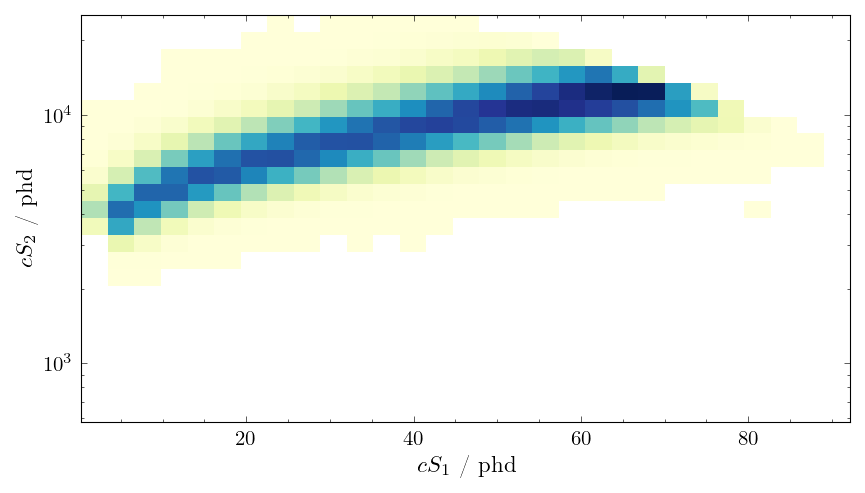

		plotting spectral PDF for 'nr_background'


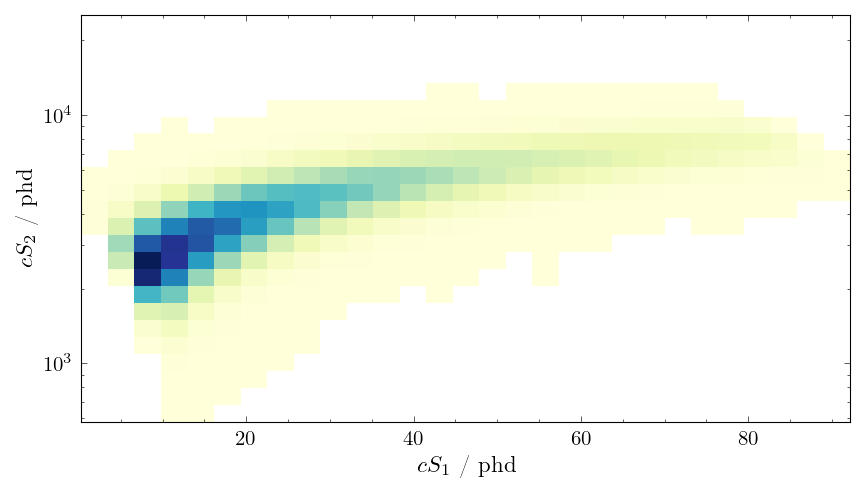

		finished within 0:03:01.950690 h'
	calculating the expected number of ER and NR background events within the binned observable space
		calculating the number of ER background events expected within the WIMP EROI

compute_expected_number_of_events_within_eroi: initializing 'compute_expected_number_of_events_within_eroi'
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

		selecting the events falling into the EROI
	k=66/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=67/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=68/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=69/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=70/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=71/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=72/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=73/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=74/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=75/200
		simulating the detector signature 

		selecting the events falling into the EROI
	k=147/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=148/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=149/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=150/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=151/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=152/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=153/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=154/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=155/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=156/200
		simulating the detector 

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	pro

		selecting the events falling into the EROI
	k=1/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=2/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=3/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=4/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=5/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=6/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=7/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=8/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=9/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=10/200
		simulating the detector signature with NEST

		selecting the events falling into the EROI
	k=84/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=85/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=86/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=87/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=88/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=89/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=90/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=91/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=92/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=93/200
		simulating the detector signature 

		selecting the events falling into the EROI
	k=165/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=166/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=167/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=168/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=169/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=170/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=171/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=172/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=173/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=174/200
		simulating the detector 

execNEST: removing -1e-6-flagged events
	selected 1622645 out of 1622850 events
extracting the wanted number of events
execNEST: executing '$ execNEST 1395168 NR 11.21294760729363 11.21294760729363 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1395146 out of 1395168 events
extracting the wanted number of events
execNEST: executing '$ execNEST 1197843 NR 12.74223665629328 12.74223665629328 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', '

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 141201 out of 141201 events
extracting the wanted number of events
execNEST: executing '$ execNEST 118134 NR 34.15228334228835 34.15228334228835 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 118134 out of 118134 events
extracting the wanted number of events
execNEST: executing '$ execNEST 97809 NR 35.681572391288 35.681572391288 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [ph

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6240 out of 6240 events
extracting the wanted number of events
execNEST: executing '$ execNEST 4680 NR 58.620908126282714 58.620908126282714 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 4680 out of 4680 events
extract

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 75 out of 75 events
extracting the wanted number of events
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


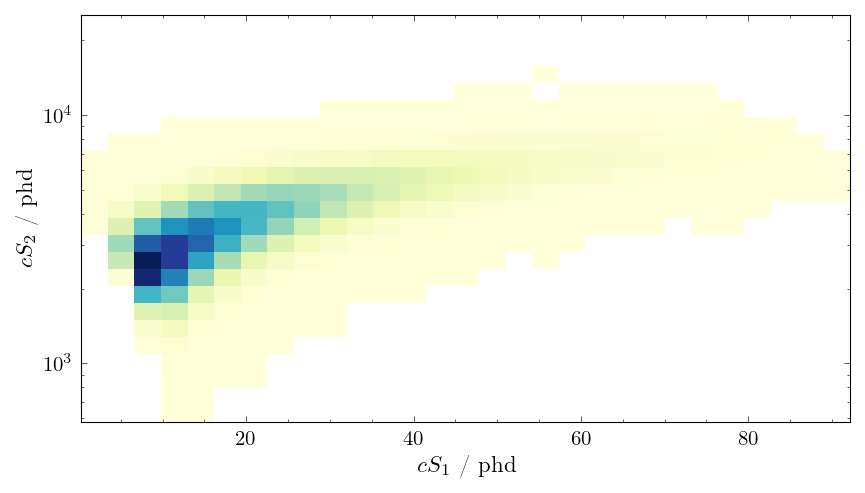

		finished within 0:22:45.025633 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI

compute_expected_number_of_events_within_eroi: initializing 'compute_expected_number_of_events_within_eroi'
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_dis

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

		selecting the events falling into the EROI
	k=66/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=67/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=68/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=69/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=70/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=71/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=72/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=73/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=74/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=75/200
		simulating the detector signature 

		selecting the events falling into the EROI
	k=147/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=148/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=149/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=150/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=151/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=152/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=153/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=154/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=155/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=156/200
		simulating the detector 

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=5/49
	drawing 10480 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=6/49
	drawing 13361 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn 

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=24/49
	drawing 10304 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=25/49
	drawing 9667 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=43/49
	drawing 10450 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=44/49
	drawing 10620 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the draw

	selected 315 out of 336 events
extracting the wanted number of events
execNEST: executing '$ execNEST 336 ER 1.6083999999999998 1.6083999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 333 out of 336 events
extracting the wanted number of events
execNEST: executing '$ execNEST 381 ER 1.934 1.934 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNE

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 534 out of 534 events
extracting the wanted number of events
execNEST: executing '$ execNEST 570 ER 7.469199999999999 7.469199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 570 out of 570 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 612 out of 612 events
extracting the wanted number of events
execNEST: executing '$ execNEST 645 ER 12.353199999999998 12.353199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 3 NR 6.625080460294687 6.625080460294687 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 582 out of 582 events
extracting the wanted number of events
execNEST: executing '$ execNEST 498 ER 5.1899999999999995 5.1899999999999995 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 498 out of 498 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extracting the wanted number of events
execNEST: executing '$ execNEST 690 ER 10.073999999999998 10.073999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 729 out of 729 events
extracting the wanted number of events
execNEST: executing '$ execNEST 738 ER 15.283599999999998 15.283599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 738 out of 738 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 431 out of 435 events
extracting the wanted number of events
execNEST: executing '$ execNEST 447 ER 1.934 1.934 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 446 out of 447 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 771 out of 771 events
extracting the wanted number of events
execNEST: executing '$ execNEST 672 ER 7.143599999999999 7.143599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 867 out of 867 events
extracting the wanted number of events
execNEST: executing '$ execNEST 840 ER 12.353199999999998 12.353199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 840 out of 840 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 906 out of 906 events
extracting the wanted number of events
execNEST: executing '$ execNEST 975 ER 17.237199999999998 17.237199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 975 out of 975 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '

execNEST: removing -1e-6-flagged events
	selected 489 out of 489 events
extracting the wanted number of events
execNEST: executing '$ execNEST 507 ER 3.887599999999999 3.887599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 507 out of 507 events
extracting the wanted number of events
execNEST: executing '$ execNEST 468 ER 4.2132 4.2132 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writin

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 660 out of 660 events
extracting the wanted number of events
execNEST: executing '$ execNEST 519 ER 9.748399999999998 9.748399999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 519 out of 519 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 834 out of 834 events
extracting the wanted number of events
execNEST: executing '$ execNEST 708 ER 14.957999999999998 14.957999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 708 out of 708 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 335 out of 357 events
extracting the wanted number of events
execNEST: executing '$ execNEST 402 ER 1.6083999999999998 1.6083999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 399 out of 402 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracting the wanted number of events
execNEST: executing '$ execNEST 705 ER 6.817999999999999 6.817999999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 705 out of 705 events
extracting the wanted number of events
execNEST: executing '$ execNEST 594 ER 7.143599999999999 7.143599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 783 out of 783 events
extracting the wanted number of events
execNEST: executing '$ execNEST 777 ER 12.353199999999998 12.353199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 777 out of 777 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 852 out of 852 events
extracting the wanted number of events
execNEST: executing '$ execNEST 870 ER 17.237199999999998 17.237199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 870 out of 870 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 519 out of 519 events
extracting the wanted number of events
execNEST: executing '$ execNEST 480 ER 4.2132 4.2132 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 480 out of 480 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 603 out of 603 events
extracting the wanted number of events
execNEST: executing '$ execNEST 666 ER 9.097199999999999 9.097199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 666 out of 666 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extracting the wanted number of events
execNEST: executing '$ execNEST 768 ER 14.306799999999997 14.306799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 768 out of 768 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 55.56233002828342 55.56233002828342 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 696 out of 696 events
extracting the wanted number of events
execNEST: executing '$ execNEST 741 ER 5.841199999999999 5.841199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 741 out of 741 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 894 out of 894 events
extracting the wanted number of events
execNEST: executing '$ execNEST 891 ER 11.050799999999999 11.050799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 891 out of 891 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1035 out of 1035 events
extracting the wanted number of events
execNEST: executing '$ execNEST 900 ER 16.260399999999997 16.260399999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 900 out of 900 events
extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 486 out of 486 events
extracting the wanted number of events
execNEST: executing '$ execNEST 513 ER 3.2363999999999997 3.2363999999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 513 out of 513 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 654 out of 654 events
extracting the wanted number of events
execNEST: executing '$ execNEST 639 ER 8.446 8.446 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 639 out of 639 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 798 out of 798 events
extracting the wanted number of events
execNEST: executing '$ execNEST 822 ER 13.655599999999998 13.655599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 822 out of 822 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 387 ER 1.2828 1.2828 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extracting the wanted number of events
execNEST: executing '$ execNEST 615 ER 6.492399999999999 6.492399999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 615 out of 615 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 828 out of 828 events
extracting the wanted number of events
execNEST: executing '$ execNEST 720 ER 11.701999999999998 11.701999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 942 out of 942 events
extracting the wanted number of events
execNEST: executing '$ execNEST 894 ER 16.9116 16.9116 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 894 out of 894 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 489 out of 489 events
extracting the wanted number of events
execNEST: executing '$ execNEST 456 ER 4.2132 4.2132 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 456 out of 456 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 546 out of 546 events
extracting the wanted number of events
execNEST: executing '$ execNEST 618 ER 9.097199999999999 9.097199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 618 out of 618 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 681 out of 681 events
extracting the wanted number of events
execNEST: executing '$ execNEST 705 ER 13.981199999999998 13.981199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 705 out of 705 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 320 out of 321 events
extracting the wanted number of events
execNEST: executing '$ execNEST 387 ER 2.2596 2.2596 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 387 out of 387 events
extracting the wanted number o

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 465 out of 465 events
extracting the wanted number of events
execNEST: executing '$ execNEST 498 ER 7.469199999999999 7.469199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 498 out of 498 events
extracting the wanted number of events
execNEST: executing '$ execNEST 561 ER 7.794799999999999 7.794799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 582 out of 582 events
extracting the wanted number of events
execNEST: executing '$ execNEST 588 ER 12.678799999999997 12.678799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 9.683658558293983 9.683658558293983 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 501 out of 501 events
extracting the wanted number of events
execNEST: executing '$ execNEST 441 ER 5.1899999999999995 5.1899999999999995 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 441 out of 441 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 477 out of 477 events
extracting the wanted number of events
execNEST: executing '$ execNEST 603 ER 10.073999999999998 10.073999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 603 out of 603 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 10.399599999999998 10.399599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 645 ER 15.609199999999998 15.609199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 324 out of 345 events
extracting the wanted number of events
execNEST: executing '$ execNEST 384 ER 1.6083999999999998 1.6083999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 381 out of 384 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 531 out of 531 events
extracting the wanted number of events
execNEST: executing '$ execNEST 645 ER 6.817999999999999 6.817999999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 7.143599999999999 7.143599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 732 out of 732 events
extracting the wanted number of events
execNEST: executing '$ execNEST 723 ER 12.353199999999998 12.353199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 3 NR 6.625080460294687 6.625080460294687 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 504 out of 504 events
extracting the wanted number of events
execNEST: executing '$ execNEST 531 ER 5.515599999999999 5.515599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 531 out of 531 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 696 out of 696 events
extracting the wanted number of events
execNEST: executing '$ execNEST 699 ER 10.399599999999998 10.399599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 699 out of 699 events
extracting the wanted number of events
execNEST: executing '$ execNEST 714 ER 10.7252 10.7252 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-IN

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 750 out of 750 events
extracting the wanted number of events
execNEST: executing '$ execNEST 756 ER 15.609199999999998 15.609199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 756 out of 756 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 399 out of 399 events
extracting the wanted number of events
execNEST: executing '$ execNEST 462 ER 3.5619999999999994 3.5619999999999994 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 462 out of 462 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 510 out of 510 events
extracting the wanted number of events
execNEST: executing '$ execNEST 501 ER 8.446 8.446 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 501 out of 501 events
extracting the wanted number of 

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 654 out of 654 events
extracting the wanted number of events
execNEST: executing '$ execNEST 678 ER 13.329999999999998 13.329999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extracting the wanted number of events
execNEST: executing '$ execNEST 651 ER 13.655599999999998 13.655599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 6 NR 9.683658558293983 9.683658558293983 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 555 out of 555 events
extracting the wanted number of events
execNEST: executing '$ execNEST 678 ER 4.864399999999999 4.864399999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extracting the wanted number of events
execNEST: executing '$ execNEST 759 ER 10.073999999999998 10.073999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 759 out of 759 events
extracting the wanted number of events
execNEST: executing '$ execNEST 795 ER 10.399599999999998 10.399599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 834 out of 834 events
extracting the wanted number of events
execNEST: executing '$ execNEST 867 ER 15.283599999999998 15.283599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 867 out of 867 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 396 out of 399 events
extracting the wanted number of events
execNEST: executing '$ execNEST 387 ER 1.934 1.934 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 386 out of 387 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 570 out of 570 events
extracting the wanted number of events
execNEST: executing '$ execNEST 657 ER 7.469199999999999 7.469199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 756 out of 756 events
extracting the wanted number of events
execNEST: executing '$ execNEST 747 ER 12.353199999999998 12.353199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extracting the wanted number of events
execNEST: executing '$ execNEST 744 ER 12.678799999999997 12.678799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 834 out of 834 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 6 NR 6.625080460294687 6.625080460294687 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 285 out of 285 events
extracting the wanted number of events
execNEST: executing '$ execNEST 315 ER 3.5619999999999994 3.5619999999999994 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 315 out of 315 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 369 out of 369 events
extracting the wanted number of events
execNEST: executing '$ execNEST 426 ER 9.097199999999999 9.097199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 426 out of 426 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 483 out of 483 events
extracting the wanted number of events
execNEST: executing '$ execNEST 528 ER 13.981199999999998 13.981199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 528 out of 528 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 321 out of 324 events
extracting the wanted number of events
execNEST: executing '$ execNEST 321 ER 1.934 1.934 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 320 out of 321 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 561 out of 561 events
extracting the wanted number of events
execNEST: executing '$ execNEST 471 ER 7.143599999999999 7.143599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 471 out of 471 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 594 ER 12.027599999999998 12.027599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 594 out of 594 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 726 out of 726 events
extracting the wanted number of events
execNEST: executing '$ execNEST 651 ER 16.9116 16.9116 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 651 out of 651 events
extracting the wanted number

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 498 out of 498 events
extracting the wanted number of events
execNEST: executing '$ execNEST 513 ER 2.910799999999999 2.910799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 513 out of 513 events
extracting the wanted number of events
execNEST: executing '$ execNEST 561 ER 3.2363999999999997 3.2363999999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extracting the wanted number of events
execNEST: executing '$ execNEST 711 ER 8.1204 8.1204 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 711 out of 711 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 885 out of 885 events
extracting the wanted number of events
execNEST: executing '$ execNEST 876 ER 13.329999999999998 13.329999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 876 out of 876 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 347 out of 348 events
extracting the wanted number of events
execNEST: executing '$ execNEST 429 ER 2.2596 2.2596 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 429 out of 429 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 597 out of 597 events
extracting the wanted number of events
execNEST: executing '$ execNEST 642 ER 7.794799999999999 7.794799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 642 out of 642 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 660 out of 660 events
extracting the wanted number of events
execNEST: executing '$ execNEST 687 ER 12.678799999999997 12.678799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 687 out of 687 events
extrac

execNEST: removing -1e-6-flagged events
	selected 771 out of 771 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 6 NR 6.625080460294687 6.625080460294687 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 8.154369509294336 8.154369509294336 200 -1 3064143'
	searc

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 504 ER 4.538799999999999 4.538799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 504 out of 504 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 717 out of 717 events
extracting the wanted number of events
execNEST: executing '$ execNEST 591 ER 9.748399999999998 9.748399999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 591 out of 591 events
extracting the wanted number of events
execNEST: executing '$ execNEST 705 ER 10.073999999999998 10.073999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 888 out of 888 events
extracting the wanted number of events
execNEST: executing '$ execNEST 756 ER 14.957999999999998 14.957999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 756 out of 756 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 55.56233002828342 55.56233002828342 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 540 out of 540 events
extracting the wanted number of events
execNEST: executing '$ execNEST 528 ER 6.166799999999999 6.166799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 528 out of 528 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 663 out of 663 events
extracting the wanted number of events
execNEST: executing '$ execNEST 723 ER 11.376399999999999 11.376399999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 711 out of 711 events
extracting the wanted number of events
execNEST: executing '$ execNEST 855 ER 16.586 16.586 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 855 out of 855 events
extracting the wanted number o

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 603 out of 603 events
extracting the wanted number of events
execNEST: executing '$ execNEST 627 ER 3.2363999999999997 3.2363999999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 627 out of 627 events
extracting the wanted number of events
execNEST: executing '$ execNEST 660 ER 3.5619999999999994 3.5619999999999994 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 786 out of 786 events
extracting the wanted number of events
execNEST: executing '$ execNEST 879 ER 9.097199999999999 9.097199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 879 out of 879 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 996 out of 996 events
extracting the wanted number of events
execNEST: executing '$ execNEST 939 ER 14.306799999999997 14.306799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 939 out of 939 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 324 out of 345 events
extracting the wanted number of events
execNEST: executing '$ execNEST 384 ER 1.6083999999999998 1.6083999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 381 out of 384 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 522 out of 522 events
extracting the wanted number of events
execNEST: executing '$ execNEST 633 ER 6.817999999999999 6.817999999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 633 out of 633 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 7.143599999999999 7.143599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extracting the wanted number of events
execNEST: executing '$ execNEST 714 ER 12.353199999999998 12.353199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 810 out of 810 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 6 NR 6.625080460294687 6.625080460294687 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 420 out of 420 events
extracting the wanted number of events
execNEST: executing '$ execNEST 477 ER 3.5619999999999994 3.5619999999999994 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 477 out of 477 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 537 ER 8.7716 8.7716 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 537 out of 537 events
extracting the wanted number of events
execNEST: executing '$ execNEST 606 ER 9.097199999999999 9.097199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)',

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 681 out of 681 events
extracting the wanted number of events
execNEST: executing '$ execNEST 705 ER 13.981199999999998 13.981199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 705 out of 705 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 414 out of 417 events
extracting the wanted number of events
execNEST: executing '$ execNEST 414 ER 1.934 1.934 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 413 out of 414 events
extracting the wanted number of 

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 7.143599999999999 7.143599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extracting the wanted number of events
execNEST: executing '$ execNEST 681 ER 7.469199999999999 7.469199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 684 out of 684 events
extracting the wanted number of events
execNEST: executing '$ execNEST 810 ER 12.027599999999998 12.027599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 810 out of 810 events
extracting the wanted number of events
execNEST: executing '$ execNEST 801 ER 12.353199999999998 12.353199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 867 out of 867 events
extracting the wanted number of events
execNEST: executing '$ execNEST 900 ER 17.237199999999998 17.237199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 900 out of 900 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extracting the wanted number of events
execNEST: executing '$ execNEST 597 ER 3.5619999999999994 3.5619999999999994 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 597 out of 597 events
extracting the wanted number of events
execNEST: executing '$ execNEST 597 ER 3.887599999999999 3.887599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extracting the wanted number of events
execNEST: executing '$ execNEST 666 ER 8.446 8.446 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 666 out of 666 events
extracting the wanted number of events
execNEST: executing '$ execNEST 690 ER 8.7716 8.7716 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 849 out of 849 events
extracting the wanted number of events
execNEST: executing '$ execNEST 858 ER 13.655599999999998 13.655599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 858 out of 858 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 6 NR 12.74223665629328 12.74223665629328 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 474 out of 474 events
extracting the wanted number of events
execNEST: executing '$ execNEST 426 ER 5.1899999999999995 5.1899999999999995 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 426 out of 426 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 594 out of 594 events
extracting the wanted number of events
execNEST: executing '$ execNEST 612 ER 10.7252 10.7252 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 612 out of 612 events
extracting the wanted number

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 612 out of 612 events
extracting the wanted number of events
execNEST: executing '$ execNEST 714 ER 15.934799999999997 15.934799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extracting the wanted number of events
execNEST: executing '$ execNEST 639 ER 16.260399999999997 16.260399999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 330 out of 330 events
extracting the wanted number of events
execNEST: executing '$ execNEST 393 ER 2.910799999999999 2.910799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 393 out of 393 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 606 out of 606 events
extracting the wanted number of events
execNEST: executing '$ execNEST 507 ER 8.1204 8.1204 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 507 out of 507 events
extracting the wanted number of events
execNEST: executing '$ execNEST 498 ER 8.446 8.446 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea 

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 675 out of 675 events
extracting the wanted number of events
execNEST: executing '$ execNEST 645 ER 13.655599999999998 13.655599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extracting the wanted number of events
execNEST: executing '$ execNEST 657 ER 13.981199999999998 13.981199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 50.974462881284474 50.974462881284474 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 669 out of 669 events
extracting the wanted number of events
execNEST: executing '$ execNEST 708 ER 5.841199999999999 5.841199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 708 out of 708 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extracting the wanted number of events
execNEST: executing '$ execNEST 852 ER 10.7252 10.7252 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 852 out of 852 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 894 out of 894 events
extracting the wanted number of events
execNEST: executing '$ execNEST 1017 ER 15.934799999999997 15.934799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1017 out of 1017 events
ext

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 435 out of 435 events
extracting the wanted number of events
execNEST: executing '$ execNEST 366 ER 2.5851999999999995 2.5851999999999995 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 366 out of 366 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 600 out of 600 events
extracting the wanted number of events
execNEST: executing '$ execNEST 654 ER 7.794799999999999 7.794799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 654 out of 654 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 675 out of 675 events
extracting the wanted number of events
execNEST: executing '$ execNEST 693 ER 12.678799999999997 12.678799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 693 out of 693 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 9.683658558293983 9.683658558293983 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 516 out of 516 events
extracting the wanted number of events
execNEST: executing '$ execNEST 447 ER 5.1899999999999995 5.1899999999999995 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 447 out of 447 events
extracting the wanted number of events
execNEST: executing '$ execNEST 480 ER 5.515599999999999 5.515599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 627 out of 627 events
extracting the wanted number of events
execNEST: executing '$ execNEST 648 ER 10.7252 10.7252 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 648 out of 648 events
extracting the wanted number

	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extracting the wanted number of events
execNEST: executing '$ execNEST 663 ER 15.609199999999998 15.609199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 663 out of 663 events
extracting the wanted number of events
execNEST: executing '$ execNEST 759 ER 15.934799999999997 15.934799999999997 200 -1 2239745'
	searching for the

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 507 out of 507 events
extracting the wanted number of events
execNEST: executing '$ execNEST 471 ER 4.2132 4.2132 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 471 out of 471 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extracting the wanted number of events
execNEST: executing '$ execNEST 654 ER 9.097199999999999 9.097199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 654 out of 654 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extracting the wanted number of events
execNEST: executing '$ execNEST 744 ER 13.981199999999998 13.981199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 744 out of 744 events
extracting the wanted number of events
execNEST: executing '$ execNEST 753 ER 14.306799999999997 14.306799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 50.974462881284474 50.974462881284474 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 537 out of 537 events
extracting the wanted number of events
execNEST: executing '$ execNEST 573 ER 5.515599999999999 5.515599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 573 out of 573 events
extracti

execNEST: executing '$ execNEST 729 ER 10.073999999999998 10.073999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 729 out of 729 events
extracting the wanted number of events
execNEST: executing '$ execNEST 753 ER 10.399599999999998 10.399599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 774 out of 774 events
extracting the wanted number of events
execNEST: executing '$ execNEST 801 ER 15.283599999999998 15.283599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 801 out of 801 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 474 out of 474 events
extracting the wanted number of events
execNEST: executing '$ execNEST 450 ER 2.5851999999999995 2.5851999999999995 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 450 out of 450 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extracting the wanted number of events
execNEST: executing '$ execNEST 759 ER 7.794799999999999 7.794799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 759 out of 759 events
extracting the wanted number of events
execNEST: executing '$ execNEST 651 ER 8.1204 8.1204 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)',

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 774 out of 774 events
extracting the wanted number of events
execNEST: executing '$ execNEST 834 ER 13.004399999999999 13.004399999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 834 out of 834 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 12.74223665629328 12.74223665629328 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 414 out of 414 events
extracting the wanted number of events
execNEST: executing '$ execNEST 435 ER 5.515599999999999 5.515599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 435 out of 435 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 609 out of 609 events
extracting the wanted number of events
execNEST: executing '$ execNEST 540 ER 11.050799999999999 11.050799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 540 out of 540 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 696 out of 696 events
extracting the wanted number of events
execNEST: executing '$ execNEST 624 ER 16.260399999999997 16.260399999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 624 out of 624 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 440 out of 441 events
extracting the wanted number of events
execNEST: executing '$ execNEST 495 ER 2.2596 2.2596 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 495 out of 495 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 663 out of 663 events
extracting the wanted number of events
execNEST: executing '$ execNEST 720 ER 7.469199999999999 7.469199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 831 out of 831 events
extracting the wanted number of events
execNEST: executing '$ execNEST 816 ER 12.678799999999997 12.678799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 8.154369509294336 8.154369509294336 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 483 out of 483 events
extracting the wanted number of events
execNEST: executing '$ execNEST 573 ER 4.864399999999999 4.864399999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 573 out of 573 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 543 out of 543 events
extracting the wanted number of events
execNEST: executing '$ execNEST 684 ER 10.073999999999998 10.073999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 684 out of 684 events
extracting the wanted number of events
execNEST: executing '$ execNEST 693 ER 10.399599999999998 10.399599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 726 out of 726 events
extracting the wanted number of events
execNEST: executing '$ execNEST 738 ER 15.283599999999998 15.283599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 738 out of 738 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 389 out of 390 events
extracting the wanted number of events
execNEST: executing '$ execNEST 474 ER 2.2596 2.2596 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 474 out of 474 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 579 out of 579 events
extracting the wanted number of events
execNEST: executing '$ execNEST 657 ER 7.469199999999999 7.469199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 756 out of 756 events
extracting the wanted number of events
execNEST: executing '$ execNEST 747 ER 12.678799999999997 12.678799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 8.154369509294336 8.154369509294336 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 486 out of 486 events
extracting the wanted number of events
execNEST: executing '$ execNEST 507 ER 3.887599999999999 3.887599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 507 out of 507 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 564 out of 564 events
extracting the wanted number of events
execNEST: executing '$ execNEST 582 ER 8.7716 8.7716 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 582 out of 582 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 729 out of 729 events
extracting the wanted number of events
execNEST: executing '$ execNEST 702 ER 13.655599999999998 13.655599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 702 out of 702 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 11.21294760729363 11.21294760729363 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 438 out of 438 events
extracting the wanted number of events
execNEST: executing '$ execNEST 396 ER 5.1899999999999995 5.1899999999999995 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 396 out of 396 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 444 out of 444 events
extracting the wanted number of events
execNEST: executing '$ execNEST 537 ER 10.073999999999998 10.073999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 537 out of 537 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extracting the wanted number of events
execNEST: executing '$ execNEST 606 ER 15.283599999999998 15.283599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 606 out of 606 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 308 out of 309 events
extracting the wanted number of events
execNEST: executing '$ execNEST 381 ER 2.2596 2.2596 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 381 out of 381 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 546 out of 546 events
extracting the wanted number of events
execNEST: executing '$ execNEST 456 ER 7.143599999999999 7.143599999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 456 out of 456 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 573 out of 573 events
extracting the wanted number of events
execNEST: executing '$ execNEST 573 ER 12.678799999999997 12.678799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 573 out of 573 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 654 out of 654 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 6 NR 6.625080460294687 6.625080460294687 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 462 out of 462 events
extracting the wanted number of events
execNEST: executing '$ execNEST 516 ER 3.5619999999999994 3.5619999999999994 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 516 out of 516 events
extrac

execNEST: removing -1e-6-flagged events
	selected 582 out of 582 events
extracting the wanted number of events
execNEST: executing '$ execNEST 600 ER 8.7716 8.7716 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 600 out of 600 events
extracting the wanted number of events
execNEST: executing '$ execNEST 666 ER 9.097199999999999 9.097199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writin

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extracting the wanted number of events
execNEST: executing '$ execNEST 747 ER 13.981199999999998 13.981199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 348 ER 1.2828 1.2828 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 531 out of 531 events
extracting the wanted number of events
execNEST: executing '$ execNEST 546 ER 5.841199999999999 5.841199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 546 out of 546 events
extracting the wanted number of events
execNEST: executing '$ execNEST 534 ER 6.166799999999999 6.166799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 741 ER 11.376399999999999 11.376399999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 741 out of 741 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extracting the wanted number of events
execNEST: executing '$ execNEST 867 ER 16.586 16.586 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 867 out of 867 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 489 out of 489 events
extracting the wanted number of events
execNEST: executing '$ execNEST 546 ER 3.5619999999999994 3.5619999999999994 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 546 out of 546 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 624 out of 624 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 8.446 8.446 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extracting the wanted number of events
execNEST: executing '$ execNEST 636 ER 8.7716 8.7716 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea 

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 768 out of 768 events
extracting the wanted number of events
execNEST: executing '$ execNEST 783 ER 13.981199999999998 13.981199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 783 out of 783 events
extracting the wanted number of events
execNEST: executing '$ execNEST 807 ER 14.306799999999997 14.306799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 217 out of 231 events
extracting the wanted number of events
execNEST: executing '$ execNEST 282 ER 1.6083999999999998 1.6083999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 280 out of 282 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 357 out of 357 events
extracting the wanted number of events
execNEST: executing '$ execNEST 342 ER 6.492399999999999 6.492399999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 342 out of 342 events
extracting the wanted number of events
execNEST: executing '$ execNEST 483 ER 6.817999999999999 6.817999999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 489 out of 489 events
extracting the wanted number of events
execNEST: executing '$ execNEST 492 ER 12.353199999999998 12.353199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 492 out of 492 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 543 ER 17.237199999999998 17.237199999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 543 out of 543 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 600 out of 600 events
extracting the wanted number of events
execNEST: executing '$ execNEST 585 ER 4.2132 4.2132 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 585 out of 585 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 4.538799999999999 4.538799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)',

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 798 out of 798 events
extracting the wanted number of events
execNEST: executing '$ execNEST 786 ER 9.422799999999999 9.422799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 786 out of 786 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 867 out of 867 events
extracting the wanted number of events
execNEST: executing '$ execNEST 969 ER 14.632399999999997 14.632399999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 969 out of 969 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 321 ER 1.2828 1.2828 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 489 out of 489 events
extracting the wanted number of events
execNEST: executing '$ execNEST 603 ER 6.817999999999999 6.817999999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 603 out of 603 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extracting the wanted number of events
execNEST: executing '$ execNEST 576 ER 11.701999999999998 11.701999999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extracting the wanted number of events
execNEST: executing '$ execNEST 660 ER 12.027599999999998 12.027599999999998 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 783 out of 783 events
extracting the wanted number of events
execNEST: executing '$ execNEST 729 ER 16.9116 16.9116 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 729 out of 729 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 393 out of 393 events
extracting the wanted number of events
execNEST: executing '$ execNEST 438 ER 2.910799999999999 2.910799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 438 out of 438 events
extracti

	selected 558 out of 558 events
extracting the wanted number of events
execNEST: executing '$ execNEST 642 ER 7.469199999999999 7.469199999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 642 out of 642 events
extracting the wanted number of events
execNEST: executing '$ execNEST 684 ER 7.794799999999999 7.794799999999999 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extracting the wanted number of events
execNEST: executing '$ execNEST 714 ER 12.678799999999997 12.678799999999997 200 -1 2239745'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 9.683658558293983 9.683658558293983 200 -1 3064143'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

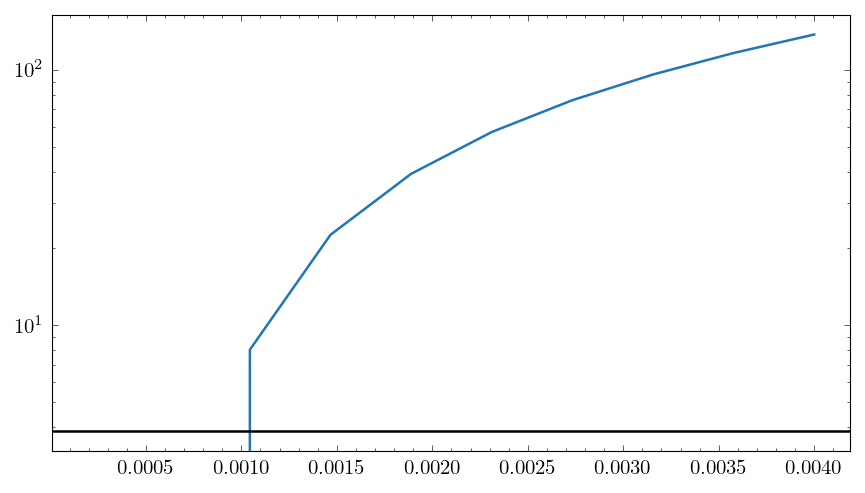

		determining the upper limit
		--->0.0009054278943144363

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.078137769483067e-17
		--->'mle_theta_er': 1.2870661405212749
		--->'mle_theta_nr': 1.0259514047975034
		defining the test statistic
		determining the upper limit
		--->0.00042721524873840194

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.352246870166223e-17
		--->'mle_theta_er': 1.0985190899733746
		--->'mle_theta_nr': 1.0200401524378169
		defining the test statistic
		determining the upper limit
		--->0.0003931894536384442

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.289959871495752e-17
		--->'mle_theta_er': 1.1427725309187604
		--->'mle_theta_nr': 1.0121303152589638
		defining the test statistic
		determining the upper limit
		--->0.0003

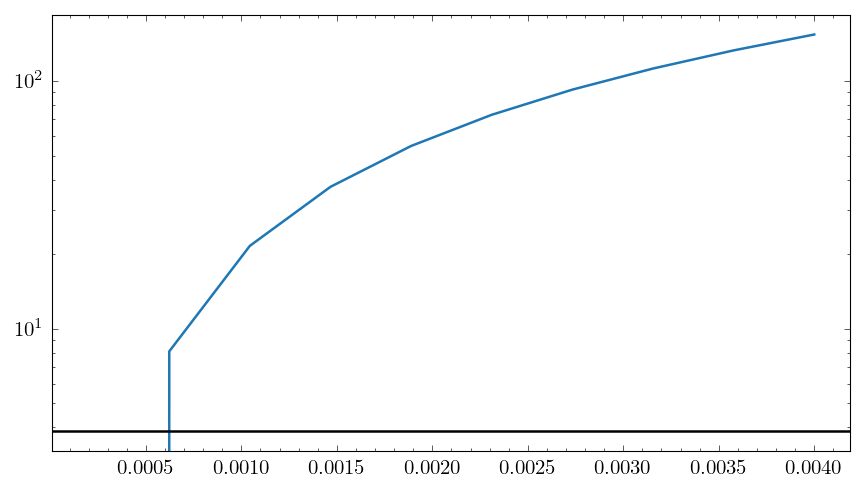

		determining the upper limit
		--->0.00045798379833063334

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.511799588584123e-17
		--->'mle_theta_er': 1.2982570077616633
		--->'mle_theta_nr': 1.0118712756837822
		defining the test statistic
		determining the upper limit
		--->0.00033346453840804314
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 0.00033346453840804314

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.47879900239743e-17
		--->'mle_theta_er': 0.9833395831319345
		--->'mle_theta_nr': 1.0229906798644484
		defining the test statistic
		determining the upper limit
		--->0.00032426186447319307

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'m

		--->'mle_sigma': 8.708854963135294e-17
		--->'mle_theta_er': 0.9034302494584606
		--->'mle_theta_nr': 1.0183846664695606
		defining the test statistic
		determining the upper limit
		--->0.00032247990838744765

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.680835948197128e-17
		--->'mle_theta_er': 0.9857784842437202
		--->'mle_theta_nr': 1.0759222553213466
		defining the test statistic
		test statistic plot


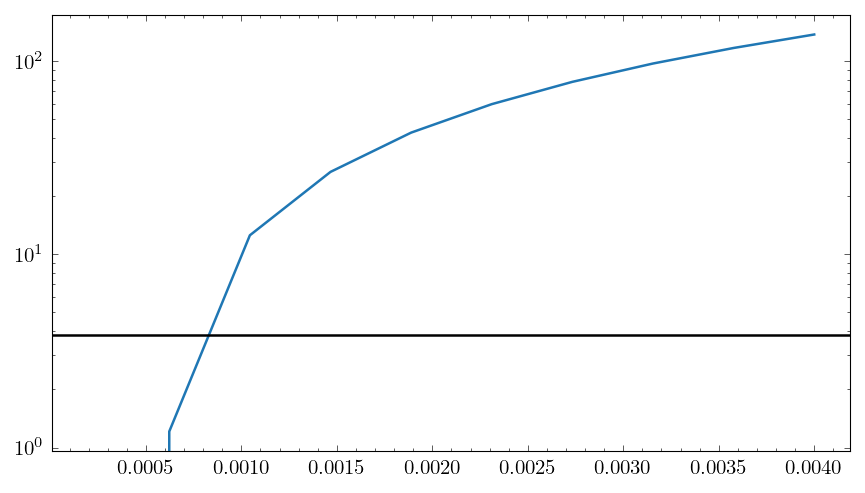

		determining the upper limit
		--->0.0007344647514593109
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 19
     iterations: 18
           root: 0.0007344647514593109
	determining the median upper limit (50 elements, different ones 50)
	'upper_limit_list' = [0.00010060245934259529, 0.0002702640162453924, 0.0002658365338019038, 0.0001047126290750469, 0.000561673778193874, 0.0009054278943144363, 0.00042721524873840194, 0.0003931894536384442, 0.000327834907123622, 9.934077550580132e-05, 0.0006182736471005393, 0.0006942682633997001, 0.00012468950502756698, 8.244384515736419e-05, 0.00044715149502560483, 0.0004753304935776546, 0.0004014698441420941, 0.00024323528673032927, 0.0007169306876224745, 0.0003684284892943568, 0.00014552355560506968, 0.00043437823423118384, 0.00045798379833063334, 0.00033346453840804314, 0.00032426186447319307, 8.833833599314214e-05, 0.0001374952068984107, 0.0002930905296648514, 0.00049406840

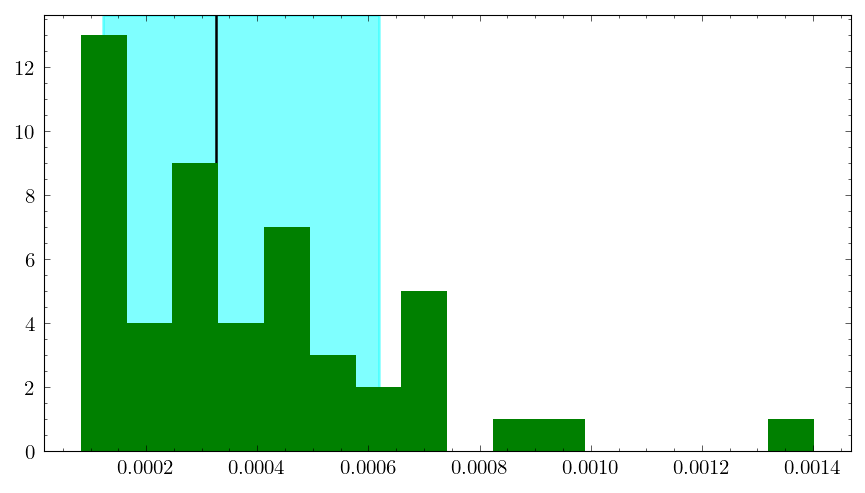

cwpec: starting WIMP mass loop with k=1/3 for 223.61 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
give_spectrum_dict: initializing 'give_spectrum_dict'
give_spectrum_dict: instantiating the 'spectrum_dict'
give_spectrum_dict: defining the combined differential rate function
give_spectrum_dict: returning 'integral'-type 'spectrum_dict'
	determining the expected number of events given the experiment's exposure
######################### starting integration #########################
######################### finishing integration #########################
	---> 'float': 13143.88268554305
	---> 'rounded': 13144
	---> 'poisson': 13148
	drawing 5000000 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 sample

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 611610 out of 611610 events
extracting the wanted number of events
execNEST: executing '$ execNEST 554976 NR 21.91797095029117 21.91797095029117 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 554976 out of 554976 events
extracting the wanted number of events
execNEST: executing '$ execNEST 502860 NR 23.447259999290818 23.447259999290818 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3D

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 124815 out of 124815 events
extracting the wanted number of events
execNEST: executing '$ execNEST 110223 NR 44.857306685285884 44.857306685285884 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 110223 out of 110223 events
extracting the wanted number of events
execNEST: executing '$ execNEST 98433 NR 46.38659573428553 46.38659573428553 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dc

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 15579 out of 15579 events
extracting the wanted number of events
execNEST: executing '$ execNEST 12939 NR 67.79664242028062 67.79664242028062 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 12939 out of 12939 events
extracting the wanted number of events
execNEST: executing '$ execNEST 10836 NR 69.32593146928026 69.32593146928026 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

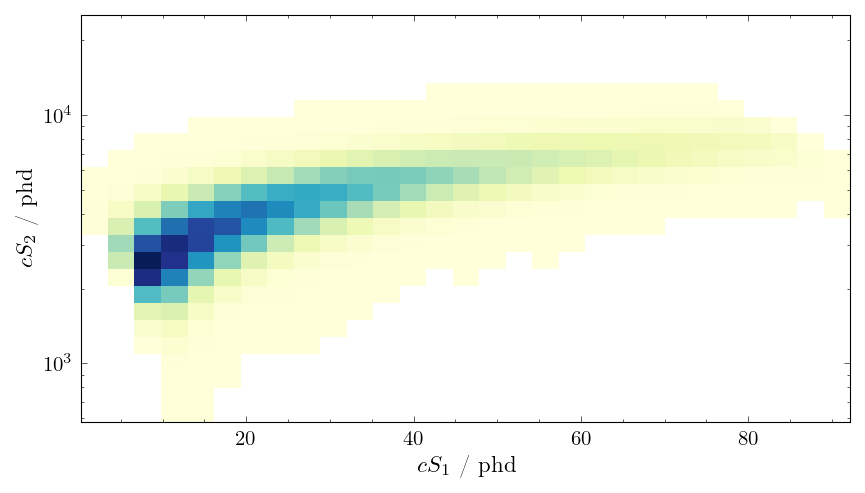

		finished within 1:25:35.903524 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI

compute_expected_number_of_events_within_eroi: initializing 'compute_expected_number_of_events_within_eroi'
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_dis

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

		selecting the events falling into the EROI
	k=66/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=67/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=68/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=69/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=70/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=71/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=72/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=73/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=74/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=75/200
		simulating the detector signature 

		selecting the events falling into the EROI
	k=147/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=148/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=149/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=150/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=151/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=152/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=153/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=154/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=155/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=156/200
		simulating the detector 

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=5/49
	drawing 11350 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=6/49
	drawing 9652 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn s

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=24/49
	drawing 12663 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=25/49
	drawing 6158 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=43/49
	drawing 9552 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=44/49
	drawing 9763 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 329 out of 354 events
extracting the wanted number of events
execNEST: executing '$ execNEST 318 ER 1.6083999999999998 1.6083999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 315 out of 318 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 561 out of 561 events
extracting the wanted number of events
execNEST: executing '$ execNEST 501 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 501 out of 501 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 633 out of 633 events
extracting the wanted number of events
execNEST: executing '$ execNEST 666 ER 11.701999999999998 11.701999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 666 out of 666 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 741 out of 741 events
extracting the wanted number of events
execNEST: executing '$ execNEST 855 ER 16.9116 16.9116 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 855 out of 855 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 561 out of 561 events
extracting the wanted number of events
execNEST: executing '$ execNEST 507 ER 3.887599999999999 3.887599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 507 out of 507 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 567 out of 567 events
extracting the wanted number of events
execNEST: executing '$ execNEST 642 ER 9.097199999999999 9.097199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 642 out of 642 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 717 out of 717 events
extracting the wanted number of events
execNEST: executing '$ execNEST 813 ER 14.306799999999997 14.306799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 31.09370524428906 31.09370524428906 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 651 out of 651 events
extracting the wanted number of events
execNEST: executing '$ execNEST 636 ER 5.515599999999999 5.515599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 636 out of 636 events
extracting the wanted number of events
execNEST: executing '$ execNEST 624 ER 5.841199999999999 5.841199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extracting the wanted number of events
execNEST: executing '$ execNEST 813 ER 10.7252 10.7252 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 840 out of 840 events
extracting the wanted number of events
execNEST: executing '$ execNEST 945 ER 15.934799999999997 15.934799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 945 out of 945 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 348 out of 348 events
extracting the wanted number of events
execNEST: executing '$ execNEST 483 ER 2.2596 2.2596 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 482 out of 483 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 684 out of 684 events
extracting the wanted number of events
execNEST: executing '$ execNEST 717 ER 7.469199999999999 7.469199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 717 out of 717 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 750 out of 750 events
extracting the wanted number of events
execNEST: executing '$ execNEST 741 ER 12.678799999999997 12.678799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 741 out of 741 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 945 out of 945 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 6 NR 6.625080460294687 6.625080460294687 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNE

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 425 out of 426 events
extracting the wanted number of events
execNEST: executing '$ execNEST 396 ER 2.5851999999999995 2.5851999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 396 out of 396 events
extracting the wanted number of events
execNEST: executing '$ execNEST 447 ER 2.910799999999999 2.910799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 639 out of 639 events
extracting the wanted number of events
execNEST: executing '$ execNEST 711 ER 8.1204 8.1204 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 711 out of 711 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 735 out of 735 events
extracting the wanted number of events
execNEST: executing '$ execNEST 795 ER 13.329999999999998 13.329999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 795 out of 795 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 23.447259999290818 23.447259999290818 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	selected 594 out of 594 events
extracting the wanted number of events
execNEST: executing '$ execNEST 600 ER 5.1899999999999995 5.1899999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 600 out of 600 events
extracting the wanted number of events
execNEST: executing '$ execNEST 612 ER 5.515599999999999 5.515599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST outpu

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 768 out of 768 events
extracting the wanted number of events
execNEST: executing '$ execNEST 765 ER 10.7252 10.7252 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 765 out of 765 events
extracting the wanted number

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extracting the wanted number of events
execNEST: executing '$ execNEST 789 ER 15.609199999999998 15.609199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 789 out of 789 events
extracting the wanted number of events
execNEST: executing '$ execNEST 888 ER 15.934799999999997 15.934799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 282 out of 282 events
extracting the wanted number of events
execNEST: executing '$ execNEST 381 ER 2.2596 2.2596 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 380 out of 381 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 597 out of 597 events
extracting the wanted number of events
execNEST: executing '$ execNEST 618 ER 7.469199999999999 7.469199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 618 out of 618 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 12.678799999999997 12.678799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 14.271525705292929 14.271525705292929 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	selected 336 out of 336 events
extracting the wanted number of events
execNEST: executing '$ execNEST 405 ER 4.2132 4.2132 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 405 out of 405 events
extracting the wanted number of events
execNEST: executing '$ execNEST 366 ER 4.538799999999999 4.538799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNE

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 465 out of 465 events
extracting the wanted number of events
execNEST: executing '$ execNEST 378 ER 9.422799999999999 9.422799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 378 out of 378 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 486 out of 486 events
extracting the wanted number of events
execNEST: executing '$ execNEST 549 ER 14.306799999999997 14.306799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extracting the wanted number of events
execNEST: executing '$ execNEST 519 ER 14.632399999999997 14.632399999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 215 out of 216 events
extracting the wanted number of events
execNEST: executing '$ execNEST 255 ER 1.934 1.934 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 255 out of 255 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 411 out of 411 events
extracting the wanted number of events
execNEST: executing '$ execNEST 495 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 495 out of 495 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracting the wanted number of events
execNEST: executing '$ execNEST 576 ER 12.027599999999998 12.027599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 696 out of 696 events
extracting the wanted number of events
execNEST: executing '$ execNEST 720 ER 17.237199999999998 17.237199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 615 out of 615 events
extracting the wanted number of events
execNEST: executing '$ execNEST 618 ER 5.1899999999999995 5.1899999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 618 out of 618 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 783 ER 10.399599999999998 10.399599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 783 out of 783 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 828 out of 828 events
extracting the wanted number of events
execNEST: executing '$ execNEST 813 ER 15.609199999999998 15.609199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 356 out of 384 events
extracting the wanted number of events
execNEST: executing '$ execNEST 357 ER 1.6083999999999998 1.6083999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 354 out of 357 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 615 out of 615 events
extracting the wanted number of events
execNEST: executing '$ execNEST 726 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 726 out of 726 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 810 out of 810 events
extracting the wanted number of events
execNEST: executing '$ execNEST 807 ER 12.027599999999998 12.027599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 807 out of 807 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 891 out of 891 events
extracting the wanted number of events
execNEST: executing '$ execNEST 981 ER 16.9116 16.9116 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 981 out of 981 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 384 out of 384 events
extracting the wanted number of events
execNEST: executing '$ execNEST 468 ER 3.5619999999999994 3.5619999999999994 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 468 out of 468 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 603 out of 603 events
extracting the wanted number of events
execNEST: executing '$ execNEST 564 ER 8.446 8.446 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 564 out of 564 events
extracting the wanted number of events
execNEST: executing '$ execNEST 504 ER 8.7716 8.7716 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 597 out of 597 events
extracting the wanted number of events
execNEST: executing '$ execNEST 597 ER 13.981199999999998 13.981199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 597 out of 597 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 23.447259999290818 23.447259999290818 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 636 out of 636 events
extracting the wanted number of events
execNEST: executing '$ execNEST 669 ER 4.864399999999999 4.864399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 669 out of 669 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 969 out of 969 events
extracting the wanted number of events
execNEST: executing '$ execNEST 747 ER 10.073999999999998 10.073999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 864 out of 864 events
extracting the wanted number of events
execNEST: executing '$ execNEST 921 ER 15.283599999999998 15.283599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 921 out of 921 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 285 out of 306 events
extracting the wanted number of events
execNEST: executing '$ execNEST 258 ER 1.6083999999999998 1.6083999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 255 out of 258 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 486 out of 486 events
extracting the wanted number of events
execNEST: executing '$ execNEST 483 ER 6.492399999999999 6.492399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 483 out of 483 events
extracting the wanted number of events
execNEST: executing '$ execNEST 564 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 648 out of 648 events
extracting the wanted number of events
execNEST: executing '$ execNEST 624 ER 11.701999999999998 11.701999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 624 out of 624 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 687 out of 687 events
extracting the wanted number of events
execNEST: executing '$ execNEST 786 ER 16.9116 16.9116 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 786 out of 786 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 354 out of 354 events
extracting the wanted number of events
execNEST: executing '$ execNEST 429 ER 3.5619999999999994 3.5619999999999994 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 429 out of 429 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 534 out of 534 events
extracting the wanted number of events
execNEST: executing '$ execNEST 468 ER 8.7716 8.7716 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 468 out of 468 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 633 out of 633 events
extracting the wanted number of events
execNEST: executing '$ execNEST 549 ER 13.655599999999998 13.655599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 29.56441619528941 29.56441619528941 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 414 out of 414 events
extracting the wanted number of events
execNEST: executing '$ execNEST 372 ER 6.166799999999999 6.166799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 372 out of 372 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 540 out of 540 events
extracting the wanted number of events
execNEST: executing '$ execNEST 495 ER 11.376399999999999 11.376399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 495 out of 495 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 582 out of 582 events
extracting the wanted number of events
execNEST: executing '$ execNEST 594 ER 16.260399999999997 16.260399999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 594 out of 594 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 248 out of 249 events
extracting the wanted number of events
execNEST: executing '$ execNEST 270 ER 1.934 1.934 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 270 out of 270 events
extracting the wanted number of 

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 477 out of 477 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracting the wanted number of events
execNEST: executing '$ execNEST 585 ER 7.143599999999999 7.143599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 597 out of 597 events
extracting the wanted number of events
execNEST: executing '$ execNEST 624 ER 12.027599999999998 12.027599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 624 out of 624 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 750 out of 750 events
extracting the wanted number of events
execNEST: executing '$ execNEST 780 ER 17.237199999999998 17.237199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 780 out of 780 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 638 out of 639 events
extracting the wanted number of events
execNEST: executing '$ execNEST 564 ER 2.5851999999999995 2.5851999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 564 out of 564 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 939 out of 939 events
extracting the wanted number of events
execNEST: executing '$ execNEST 864 ER 7.794799999999999 7.794799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 864 out of 864 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1008 out of 1008 events
extracting the wanted number of events
execNEST: executing '$ execNEST 1116 ER 13.004399999999999 13.004399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1116 out of 1116 events
e

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 31.09370524428906 31.09370524428906 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 465 out of 465 events
extracting the wanted number of events
execNEST: executing '$ execNEST 462 ER 5.841199999999999 5.841199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 462 out of 462 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 10.7252 10.7252 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extracting the wanted number of events
execNEST: executing '$ execNEST 612 ER 11.050799999999999 11.050799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-IN

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 651 out of 651 events
extracting the wanted number of events
execNEST: executing '$ execNEST 684 ER 15.934799999999997 15.934799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 684 out of 684 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 383 out of 384 events
extracting the wanted number of events
execNEST: executing '$ execNEST 363 ER 2.5851999999999995 2.5851999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 363 out of 363 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extracting the wanted number of events
execNEST: executing '$ execNEST 576 ER 7.794799999999999 7.794799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 630 out of 630 events
extracting the wanted number of events
execNEST: executing '$ execNEST 687 ER 13.004399999999999 13.004399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 687 out of 687 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 31.09370524428906 31.09370524428906 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extracting the wanted number of events
execNEST: executing '$ execNEST 630 ER 5.515599999999999 5.515599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 630 out of 630 events
extracting the wanted number of events
execNEST: executing '$ execNEST 624 ER 5.841199999999999 5.841199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 804 out of 804 events
extracting the wanted number of events
execNEST: executing '$ execNEST 801 ER 10.7252 10.7252 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 801 out of 801 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 828 out of 828 events
extracting the wanted number of events
execNEST: executing '$ execNEST 933 ER 15.934799999999997 15.934799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 933 out of 933 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 255 out of 258 events
extracting the wanted number of events
execNEST: executing '$ execNEST 288 ER 1.934 1.934 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 288 out of 288 events
extracting the wanted number of 

	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 570 out of 570 events
extracting the wanted number of events
execNEST: executing '$ execNEST 600 ER 7.143599999999999 7.143599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 600 out of 600 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 7.469199999999999 7.469199999999999 200 -1 1447204'
	searching for the out

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 642 out of 642 events
extracting the wanted number of events
execNEST: executing '$ execNEST 579 ER 12.353199999999998 12.353199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 579 out of 579 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 807 out of 807 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 6 NR 6.625080460294687 6.625080460294687 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 501 out of 501 events
extracting the wanted number of events
execNEST: executing '$ execNEST 636 ER 3.5619999999999994 3.5619999999999994 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 636 out of 636 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 798 out of 798 events
extracting the wanted number of events
execNEST: executing '$ execNEST 750 ER 8.446 8.446 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 750 out of 750 events
extracting the wanted number of 

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 843 out of 843 events
extracting the wanted number of events
execNEST: executing '$ execNEST 870 ER 13.329999999999998 13.329999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 870 out of 870 events
extracting the wanted number of events
execNEST: executing '$ execNEST 801 ER 13.655599999999998 13.655599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 23.447259999290818 23.447259999290818 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	selected 453 out of 453 events
extracting the wanted number of events
execNEST: executing '$ execNEST 453 ER 4.864399999999999 4.864399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 453 out of 453 events
extracting the wanted number of events
execNEST: executing '$ execNEST 471 ER 5.1899999999999995 5.1899999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST outpu

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 492 out of 492 events
extracting the wanted number of events
execNEST: executing '$ execNEST 660 ER 9.748399999999998 9.748399999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 660 out of 660 events
extracting the wanted number of events
execNEST: executing '$ execNEST 561 ER 10.073999999999998 10.073999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 636 ER 14.957999999999998 14.957999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 636 out of 636 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 387 ER 1.2828 1.2828 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 651 out of 651 events
extracting the wanted number of events
execNEST: executing '$ execNEST 675 ER 6.166799999999999 6.166799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 675 out of 675 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 6.492399999999999 6.492399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 810 out of 810 events
extracting the wanted number of events
execNEST: executing '$ execNEST 813 ER 11.701999999999998 11.701999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extrac

execNEST: executing '$ execNEST 1005 ER 16.260399999999997 16.260399999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1005 out of 1005 events
extracting the wanted number of events
execNEST: executing '$ execNEST 897 ER 16.586 16.586 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNE

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 266 out of 267 events
extracting the wanted number of events
execNEST: executing '$ execNEST 231 ER 2.5851999999999995 2.5851999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 231 out of 231 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 393 out of 393 events
extracting the wanted number of events
execNEST: executing '$ execNEST 387 ER 7.469199999999999 7.469199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 387 out of 387 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 423 out of 423 events
extracting the wanted number of events
execNEST: executing '$ execNEST 378 ER 12.353199999999998 12.353199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 378 out of 378 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 531 out of 531 events
extracting the wanted number of events
execNEST: executing '$ execNEST 465 ER 17.237199999999998 17.237199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 465 out of 465 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 492 out of 492 events
extracting the wanted number of events
execNEST: executing '$ execNEST 516 ER 3.2363999999999997 3.2363999999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 516 out of 516 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extracting the wanted number of events
execNEST: executing '$ execNEST 771 ER 8.446 8.446 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 771 out of 771 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 894 out of 894 events
extracting the wanted number of events
execNEST: executing '$ execNEST 831 ER 13.655599999999998 13.655599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 831 out of 831 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 228 out of 246 events
extracting the wanted number of events
execNEST: executing '$ execNEST 207 ER 1.6083999999999998 1.6083999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 206 out of 207 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 408 out of 408 events
extracting the wanted number of events
execNEST: executing '$ execNEST 405 ER 6.492399999999999 6.492399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 405 out of 405 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 534 out of 534 events
extracting the wanted number of events
execNEST: executing '$ execNEST 549 ER 11.701999999999998 11.701999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 582 out of 582 events
extracting the wanted number of events
execNEST: executing '$ execNEST 687 ER 16.9116 16.9116 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 687 out of 687 events
extracting the wanted number

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 585 out of 585 events
extracting the wanted number of events
execNEST: executing '$ execNEST 525 ER 3.887599999999999 3.887599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 579 ER 4.2132 4.2132 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)',

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extracting the wanted number of events
execNEST: executing '$ execNEST 654 ER 9.097199999999999 9.097199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 654 out of 654 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 741 out of 741 events
extracting the wanted number of events
execNEST: executing '$ execNEST 828 ER 14.306799999999997 14.306799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 828 out of 828 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 301 out of 324 events
extracting the wanted number of events
execNEST: executing '$ execNEST 291 ER 1.6083999999999998 1.6083999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 288 out of 291 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 534 out of 534 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 681 out of 681 events
extracting the wanted number of events
execNEST: executing '$ execNEST 708 ER 12.027599999999998 12.027599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 708 out of 708 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 870 out of 870 events
extracting the wanted number of events
execNEST: executing '$ execNEST 870 ER 17.237199999999998 17.237199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 870 out of 870 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 507 out of 507 events
extracting the wanted number of events
execNEST: executing '$ execNEST 477 ER 3.887599999999999 3.887599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 477 out of 477 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 531 out of 531 events
extracting the wanted number of events
execNEST: executing '$ execNEST 606 ER 9.097199999999999 9.097199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 606 out of 606 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 651 out of 651 events
extracting the wanted number of events
execNEST: executing '$ execNEST 738 ER 14.306799999999997 14.306799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 738 out of 738 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 270 out of 291 events
extracting the wanted number of events
execNEST: executing '$ execNEST 249 ER 1.6083999999999998 1.6083999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 248 out of 249 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 477 out of 477 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 597 out of 597 events
extracting the wanted number of events
execNEST: executing '$ execNEST 624 ER 12.027599999999998 12.027599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 624 out of 624 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 750 out of 750 events
extracting the wanted number of events
execNEST: executing '$ execNEST 780 ER 17.237199999999998 17.237199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 780 out of 780 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 543 out of 543 events
extracting the wanted number of events
execNEST: executing '$ execNEST 495 ER 3.887599999999999 3.887599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 495 out of 495 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracting the wanted number of events
execNEST: executing '$ execNEST 639 ER 9.097199999999999 9.097199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 639 out of 639 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extracting the wanted number of events
execNEST: executing '$ execNEST 792 ER 14.306799999999997 14.306799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 792 out of 792 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 29.56441619528941 29.56441619528941 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	selected 552 out of 552 events
extracting the wanted number of events
execNEST: executing '$ execNEST 555 ER 5.515599999999999 5.515599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 555 out of 555 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 5.841199999999999 5.841199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 717 out of 717 events
extracting the wanted number of events
execNEST: executing '$ execNEST 693 ER 10.7252 10.7252 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 693 out of 693 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extracting the wanted number of events
execNEST: executing '$ execNEST 810 ER 15.934799999999997 15.934799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 810 out of 810 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 429 out of 429 events
extracting the wanted number of events
execNEST: executing '$ execNEST 465 ER 2.910799999999999 2.910799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 465 out of 465 events
extracting the wanted number of events
execNEST: executing '$ execNEST 492 ER 3.2363999999999997 3.2363999999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 684 out of 684 events
extracting the wanted number of events
execNEST: executing '$ execNEST 780 ER 8.1204 8.1204 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 780 out of 780 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 726 out of 726 events
extracting the wanted number of events
execNEST: executing '$ execNEST 810 ER 13.004399999999999 13.004399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 810 out of 810 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 359 out of 387 events
extracting the wanted number of events
execNEST: executing '$ execNEST 360 ER 1.6083999999999998 1.6083999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 357 out of 360 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 669 out of 669 events
extracting the wanted number of events
execNEST: executing '$ execNEST 615 ER 6.492399999999999 6.492399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 615 out of 615 events
extracting the wanted number of events
execNEST: executing '$ execNEST 732 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extracting the wanted number of events
execNEST: executing '$ execNEST 816 ER 12.027599999999998 12.027599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extrac

	selected 1002 out of 1002 events
extracting the wanted number of events
execNEST: executing '$ execNEST 894 ER 16.586 16.586 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 894 out of 894 events
extracting the wanted number of events
execNEST: executing '$ execNEST 984 ER 16.9116 16.9116 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execN

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 504 out of 504 events
extracting the wanted number of events
execNEST: executing '$ execNEST 471 ER 3.887599999999999 3.887599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 471 out of 471 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 594 ER 9.097199999999999 9.097199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 594 out of 594 events
extracting the wanted number of events
execNEST: executing '$ execNEST 525 ER 9.422799999999999 9.422799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extracting the wanted number of events
execNEST: executing '$ execNEST 720 ER 14.306799999999997 14.306799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 290 out of 312 events
extracting the wanted number of events
execNEST: executing '$ execNEST 264 ER 1.6083999999999998 1.6083999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 261 out of 264 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 483 out of 483 events
extracting the wanted number of events
execNEST: executing '$ execNEST 591 ER 6.817999999999999 6.817999999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 591 out of 591 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extracting the wanted number of events
execNEST: executing '$ execNEST 651 ER 12.027599999999998 12.027599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 651 out of 651 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 804 out of 804 events
extracting the wanted number of events
execNEST: executing '$ execNEST 816 ER 17.237199999999998 17.237199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 333 out of 333 events
extracting the wanted number of events
execNEST: executing '$ execNEST 417 ER 3.5619999999999994 3.5619999999999994 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 417 out of 417 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 522 out of 522 events
extracting the wanted number of events
execNEST: executing '$ execNEST 510 ER 8.446 8.446 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 510 out of 510 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 609 out of 609 events
extracting the wanted number of events
execNEST: executing '$ execNEST 531 ER 13.655599999999998 13.655599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 531 out of 531 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 23.447259999290818 23.447259999290818 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 573 out of 573 events
extracting the wanted number of events
execNEST: executing '$ execNEST 531 ER 4.538799999999999 4.538799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 531 out of 531 events
extracting the wanted number of events
execNEST: executing '$ execNEST 543 ER 4.864399999999999 4.864399999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 594 out of 594 events
extracting the wanted number of events
execNEST: executing '$ execNEST 765 ER 9.748399999999998 9.748399999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 765 out of 765 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 801 out of 801 events
extracting the wanted number of events
execNEST: executing '$ execNEST 762 ER 14.957999999999998 14.957999999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 762 out of 762 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 273 ER 1.2828 1.2828 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 468 out of 468 events
extracting the wanted number of events
execNEST: executing '$ execNEST 435 ER 6.166799999999999 6.166799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 435 out of 435 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 624 out of 624 events
extracting the wanted number of events
execNEST: executing '$ execNEST 612 ER 11.050799999999999 11.050799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 612 out of 612 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extracting the wanted number of events
execNEST: executing '$ execNEST 669 ER 16.260399999999997 16.260399999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 669 out of 669 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 414 out of 414 events
extracting the wanted number of events
execNEST: executing '$ execNEST 510 ER 3.5619999999999994 3.5619999999999994 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 510 out of 510 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 627 out of 627 events
extracting the wanted number of events
execNEST: executing '$ execNEST 543 ER 8.7716 8.7716 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 543 out of 543 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extracting the wanted number of events
execNEST: executing '$ execNEST 669 ER 13.981199999999998 13.981199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 669 out of 669 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 20.38868190129152 20.38868190129152 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 477 out of 477 events
extracting the wanted number of events
execNEST: executing '$ execNEST 516 ER 4.2132 4.2132 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 516 out of 516 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 615 out of 615 events
extracting the wanted number of events
execNEST: executing '$ execNEST 543 ER 9.422799999999999 9.422799999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 543 out of 543 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 750 out of 750 events
extracting the wanted number of events
execNEST: executing '$ execNEST 729 ER 14.632399999999997 14.632399999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 729 out of 729 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 24.976549048290465 24.976549048290465 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 474 out of 474 events
extracting the wanted number of events
execNEST: executing '$ execNEST 489 ER 5.1899999999999995 5.1899999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 489 out of 489 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 582 out of 582 events
extracting the wanted number of events
execNEST: executing '$ execNEST 645 ER 10.399599999999998 10.399599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extrac

execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 681 ER 15.283599999999998 15.283599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 681 out of 681 events
extracting the wanted number of events
execNEST: executing '$ execNEST 678 ER 15.609199999999998 15.609199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcor

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 420 out of 420 events
extracting the wanted number of events
execNEST: executing '$ execNEST 411 ER 3.2363999999999997 3.2363999999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 411 out of 411 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extracting the wanted number of events
execNEST: executing '$ execNEST 624 ER 8.446 8.446 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 624 out of 624 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 729 out of 729 events
extracting the wanted number of events
execNEST: executing '$ execNEST 657 ER 13.655599999999998 13.655599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 20.38868190129152 20.38868190129152 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 351 out of 351 events
extracting the wanted number of events
execNEST: executing '$ execNEST 396 ER 5.1899999999999995 5.1899999999999995 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 396 out of 396 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 471 out of 471 events
extracting the wanted number of events
execNEST: executing '$ execNEST 489 ER 10.399599999999998 10.399599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 489 out of 489 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 564 out of 564 events
extracting the wanted number of events
execNEST: executing '$ execNEST 546 ER 15.609199999999998 15.609199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 546 out of 546 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 264 out of 267 events
extracting the wanted number of events
execNEST: executing '$ execNEST 291 ER 1.934 1.934 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 291 out of 291 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 591 out of 591 events
extracting the wanted number of events
execNEST: executing '$ execNEST 618 ER 7.143599999999999 7.143599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 618 out of 618 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 660 out of 660 events
extracting the wanted number of events
execNEST: executing '$ execNEST 597 ER 12.353199999999998 12.353199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 597 out of 597 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 819 out of 819 events
extracting the wanted number of events
execNEST: executing '$ execNEST 825 ER 17.237199999999998 17.237199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 825 out of 825 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 438 out of 438 events
extracting the wanted number of events
execNEST: executing '$ execNEST 543 ER 3.5619999999999994 3.5619999999999994 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 543 out of 543 events
extracting the wanted number of events
execNEST: executing '$ execNEST 495 ER 3.887599999999999 3.887599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 555 out of 555 events
extracting the wanted number of events
execNEST: executing '$ execNEST 639 ER 9.097199999999999 9.097199999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 639 out of 639 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extracting the wanted number of events
execNEST: executing '$ execNEST 792 ER 14.306799999999997 14.306799999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 792 out of 792 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 354 out of 357 events
extracting the wanted number of events
execNEST: executing '$ execNEST 381 ER 1.934 1.934 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 381 out of 381 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 726 out of 726 events
extracting the wanted number of events
execNEST: executing '$ execNEST 717 ER 7.143599999999999 7.143599999999999 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 717 out of 717 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 807 out of 807 events
extracting the wanted number of events
execNEST: executing '$ execNEST 822 ER 12.353199999999998 12.353199999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 822 out of 822 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1011 out of 1011 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 6 NR 6.625080460294687 6.625080460294687 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Ex

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 381 out of 381 events
extracting the wanted number of events
execNEST: executing '$ execNEST 369 ER 3.2363999999999997 3.2363999999999997 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 369 out of 369 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 573 out of 573 events
extracting the wanted number of events
execNEST: executing '$ execNEST 543 ER 8.446 8.446 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 543 out of 543 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 651 out of 651 events
extracting the wanted number of events
execNEST: executing '$ execNEST 576 ER 13.655599999999998 13.655599999999998 200 -1 1447204'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 20.38868190129152 20.38868190129152 200 -1 6505570'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

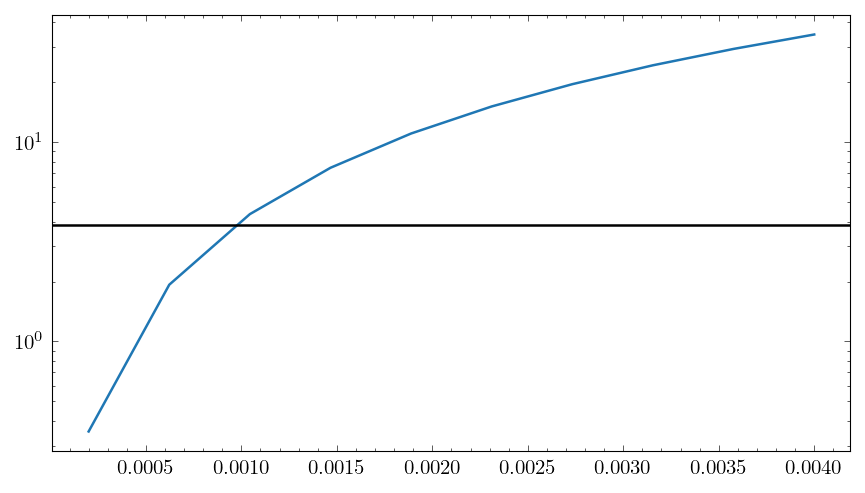

		determining the upper limit
		--->0.0009638759491786215

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.575081656052164e-17
		--->'mle_theta_er': 0.9328570587905225
		--->'mle_theta_nr': 0.9779260533638445
		defining the test statistic
		determining the upper limit
		--->0.0006847107632826924

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0424024521879916e-16
		--->'mle_theta_er': 0.693511794425576
		--->'mle_theta_nr': 0.9764048923988221
		defining the test statistic
		determining the upper limit
		--->0.0005689856624800881

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0517567093702814e-16
		--->'mle_theta_er': 0.8221001084110675
		--->'mle_theta_nr': 0.9422781546337649
		defining the test statistic
		determining the upper limit
		--->0.0003

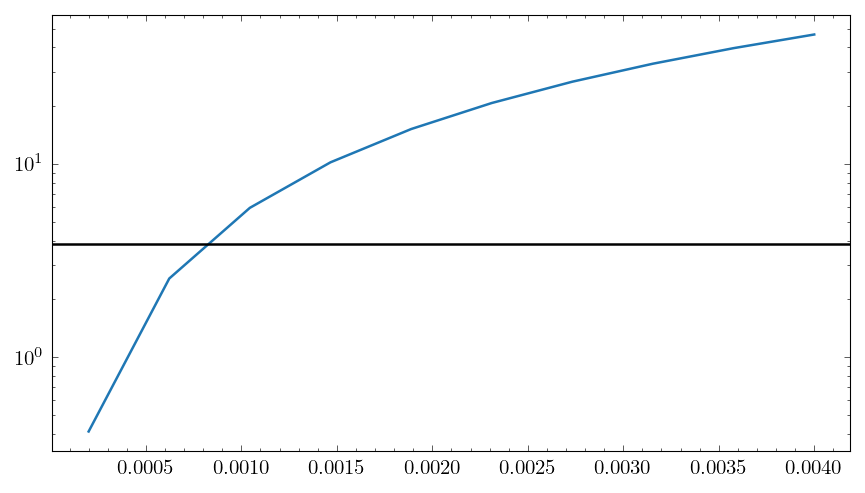

		determining the upper limit
		--->0.0007997194935090163

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.757833691540298e-17
		--->'mle_theta_er': 0.9035937301940271
		--->'mle_theta_nr': 1.019551272725701
		defining the test statistic
		determining the upper limit
		--->0.0010519174321612164

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.427574044018572e-17
		--->'mle_theta_er': 1.4512339782893342
		--->'mle_theta_nr': 0.9677321702891362
		defining the test statistic
		test statistic plot


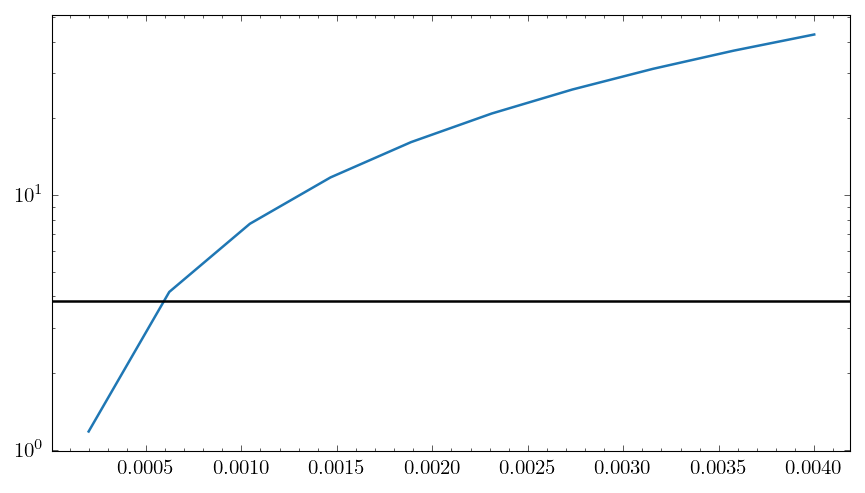

		determining the upper limit
		--->0.0005806925485171568

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0076215849873606e-16
		--->'mle_theta_er': 0.848270878267725
		--->'mle_theta_nr': 0.9909570345959835
		defining the test statistic
		determining the upper limit
		--->0.0009368854709685952

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.435703619680803e-17
		--->'mle_theta_er': 0.9354626362506535
		--->'mle_theta_nr': 0.9618663824963383
		defining the test statistic
		determining the upper limit
		--->0.00047883926910308536

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.403266663580984e-17
		--->'mle_theta_er': 1.1495582007420198
		--->'mle_theta_nr': 1.0043308184559148
		defining the test statistic
		determining the upper limit
		--->0.0009

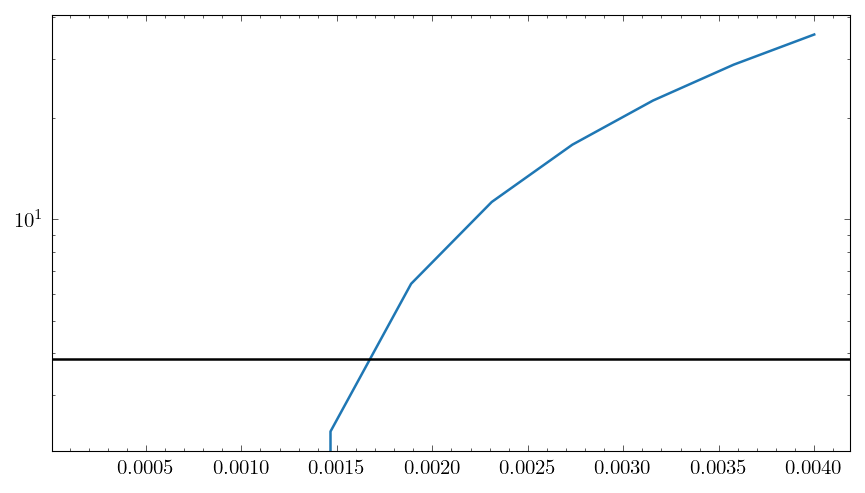

		determining the upper limit
		--->0.0016323277938524662

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.105875056080822e-17
		--->'mle_theta_er': 1.1712723063881518
		--->'mle_theta_nr': 0.9389612117311121
		defining the test statistic
		determining the upper limit
		--->0.0003266463819918512
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 0.0003266463819918512

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0078051714276164e-16
		--->'mle_theta_er': 0.8039478155153597
		--->'mle_theta_nr': 1.0629563129848498
		defining the test statistic
		determining the upper limit
		--->0.002508560406986008

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_si

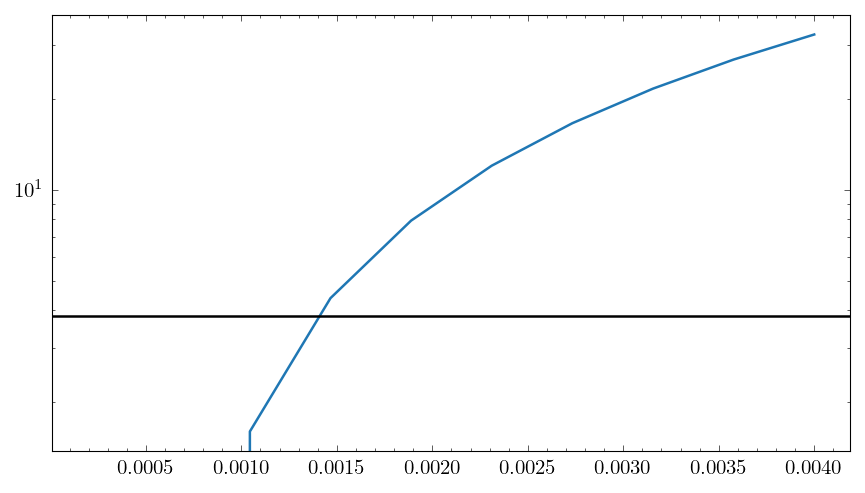

		determining the upper limit
		--->0.001392609586912605

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.250662989403736e-17
		--->'mle_theta_er': 0.9318622057169219
		--->'mle_theta_nr': 0.973613579668497
		defining the test statistic
		determining the upper limit
		--->0.0006110424959530654

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.40606964444043e-17
		--->'mle_theta_er': 0.9051642722811387
		--->'mle_theta_nr': 1.0091481554694355
		defining the test statistic
		determining the upper limit
		--->0.0009475815446463494

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.341484101743453e-17
		--->'mle_theta_er': 0.9865444839396453
		--->'mle_theta_nr': 1.0240025055079154
		defining the test statistic
		determining the upper limit
		--->0.00186853

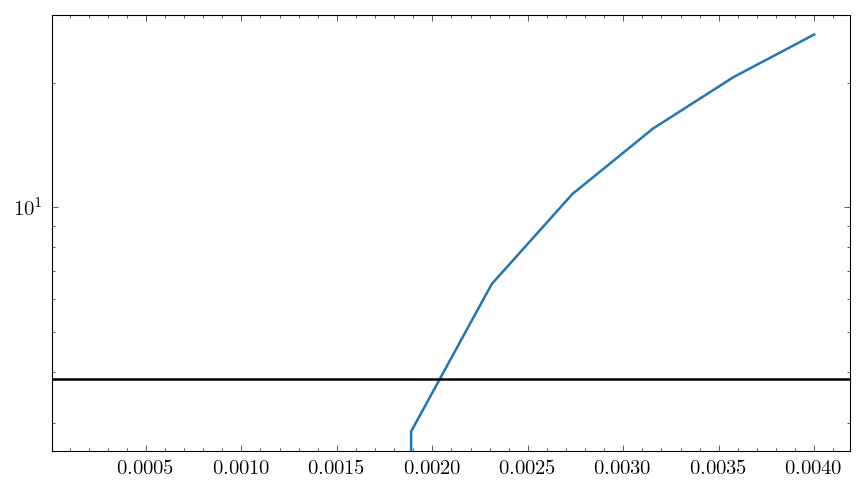

		determining the upper limit
		--->0.00200956712106534

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.571706240833369e-17
		--->'mle_theta_er': 1.0251709379194283
		--->'mle_theta_nr': 0.9617286111482457
		defining the test statistic
		determining the upper limit
		--->0.0004884427830341459

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.959940381222921e-17
		--->'mle_theta_er': 0.8511092827933991
		--->'mle_theta_nr': 0.9988932989016253
		defining the test statistic
		determining the upper limit
		--->0.0007710094539220268

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.417934158377603e-17
		--->'mle_theta_er': 0.9474528143298524
		--->'mle_theta_nr': 1.0013924626517983
		defining the test statistic
		determining the upper limit
		--->0.0010954

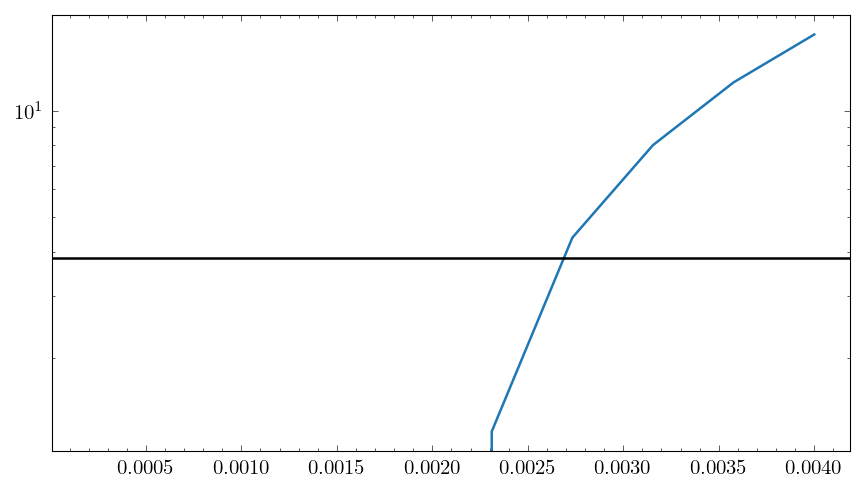

		determining the upper limit
		--->0.0026656766772891714

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.3171842841324e-17
		--->'mle_theta_er': 0.9841270953294504
		--->'mle_theta_nr': 0.9992176756452018
		defining the test statistic
		determining the upper limit
		--->0.001142816672204572

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.756772802901874e-17
		--->'mle_theta_er': 1.2124912418713976
		--->'mle_theta_nr': 1.0370425318339536
		defining the test statistic
		determining the upper limit
		--->0.0018370455672996778

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0502995124109208e-16
		--->'mle_theta_er': 0.8209164382087031
		--->'mle_theta_nr': 0.9421948815636898
		defining the test statistic
		determining the upper limit
		--->0.0003470

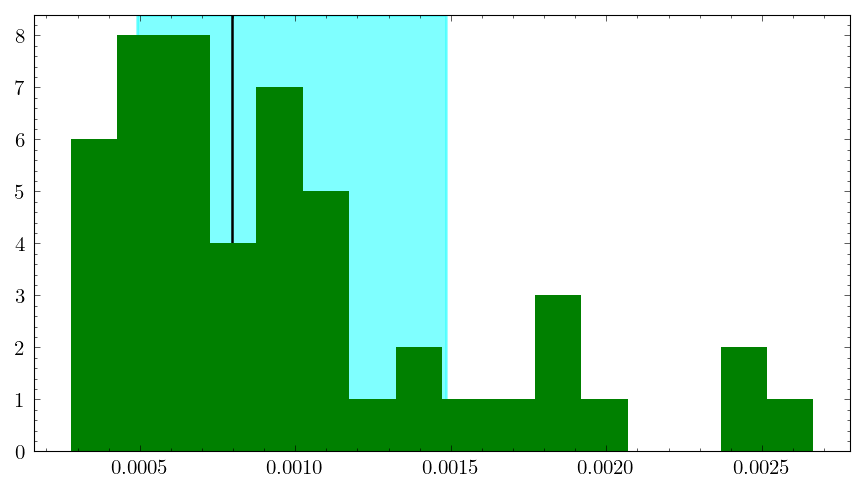

cwpec: starting WIMP mass loop with k=2/3 for 1000.00 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
give_spectrum_dict: initializing 'give_spectrum_dict'
give_spectrum_dict: instantiating the 'spectrum_dict'
give_spectrum_dict: defining the combined differential rate function
give_spectrum_dict: returning 'integral'-type 'spectrum_dict'
	determining the expected number of events given the experiment's exposure
######################### starting integration #########################
######################### finishing integration #########################
	---> 'float': 3176.679958762763
	---> 'rounded': 3177
	---> 'poisson': 3178
	drawing 5000000 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 612609 out of 612609 events
extracting the wanted number of events
execNEST: executing '$ execNEST 559206 NR 21.91797095029117 21.91797095029117 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 559206 out of 559206 events
extracting the wanted number of events
execNEST: executing '$ execNEST 510696 NR 23.447259999290818 23.447259999290818 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3D

	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 138321 out of 138321 events
extracting the wanted number of events
execNEST: executing '$ execNEST 123669 NR 44.857306685285884 44.857306685285884 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 123669 out of 123669 events
extracting the wanted number of eve

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 19044 out of 19044 events
extracting the wanted number of events
execNEST: executing '$ execNEST 16470 NR 67.79664242028062 67.79664242028062 200 -1 1'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 16470 out of 16470 events
extr

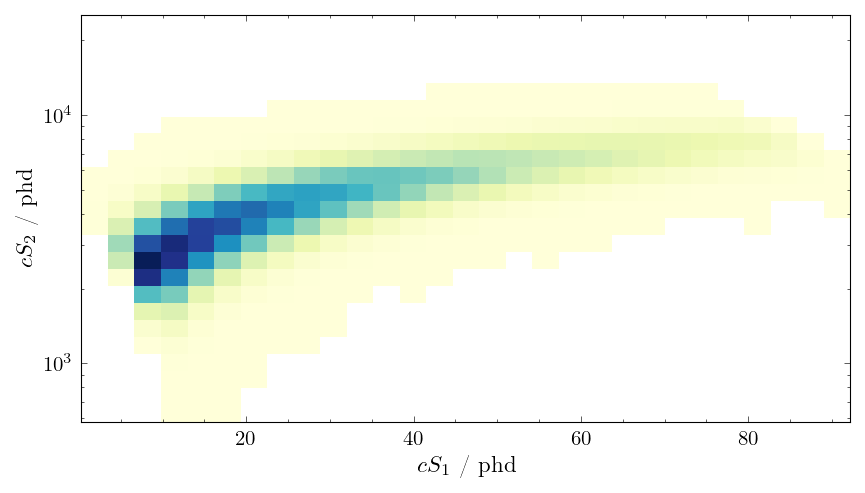

		finished within 1:17:35.067031 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI

compute_expected_number_of_events_within_eroi: initializing 'compute_expected_number_of_events_within_eroi'
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_dis

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'gene

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
compute_expected_number_of_events_within_eroi: simulating '200'-many signatures
	k=0/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=1/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=2/200
		simulating t

		selecting the events falling into the EROI
	k=74/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=75/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=76/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=77/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=78/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=79/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=80/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=81/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=82/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=83/200
		simulating the detector signature 

		selecting the events falling into the EROI
	k=155/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=156/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=157/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=158/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=159/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=160/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=161/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=162/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=163/200
		simulating the detector signature with NEST
		selecting the events falling into the EROI
	k=164/200
		simulating the detector 

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=7/49
	drawing 9726 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=8/49
	drawing 9269 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn sa

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=26/49
	drawing 13209 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=27/49
	drawing 11998 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the draw

'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=45/49
	drawing 8581 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn samples
	updating the 'integral'-type 'spectrum_dict'
	k=46/49
	drawing 9865 samples from the custom spectrum pdf
'generate_samples_from_discrete_pdf': drawing samples form cumulative pdf
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' indices
	processed 0 samples
'generate_samples_from_discrete_pdf': determining the drawn samples' 'random_variable_values' values
	histogramming the drawn 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 284 out of 297 events
extracting the wanted number of events
execNEST: executing '$ execNEST 318 ER 1.6083999999999998 1.6083999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 313 out of 318 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 564 out of 564 events
extracting the wanted number of events
execNEST: executing '$ execNEST 531 ER 6.817999999999999 6.817999999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 531 out of 531 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 687 out of 687 events
extracting the wanted number of events
execNEST: executing '$ execNEST 744 ER 12.027599999999998 12.027599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 744 out of 744 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 807 out of 807 events
extracting the wanted number of events
execNEST: executing '$ execNEST 828 ER 17.237199999999998 17.237199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 828 out of 828 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 567 out of 567 events
extracting the wanted number of events
execNEST: executing '$ execNEST 489 ER 3.5619999999999994 3.5619999999999994 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 489 out of 489 events
extracting the wanted number of events
execNEST: executing '$ execNEST 462 ER 3.887599999999999 3.887599999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 630 out of 630 events
extracting the wanted number of events
execNEST: executing '$ execNEST 648 ER 9.097199999999999 9.097199999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 648 out of 648 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 702 out of 702 events
extracting the wanted number of events
execNEST: executing '$ execNEST 840 ER 14.306799999999997 14.306799999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 840 out of 840 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 52.503751930284125 52.503751930284125 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 537 out of 537 events
extracting the wanted number of events
execNEST: executing '$ execNEST 525 ER 5.841199999999999 5.841199999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 612 ER 6.166799999999999 6.166799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extracting the wanted number of events
execNEST: executing '$ execNEST 783 ER 11.050799999999999 11.050799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 783 out of 783 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 873 out of 873 events
extracting the wanted number of events
execNEST: executing '$ execNEST 717 ER 16.260399999999997 16.260399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 717 out of 717 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 522 out of 522 events
extracting the wanted number of events
execNEST: executing '$ execNEST 444 ER 3.5619999999999994 3.5619999999999994 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 444 out of 444 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 8.446 8.446 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extracting the wanted number of events
execNEST: executing '$ execNEST 720 ER 13.655599999999998 13.655599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 52.503751930284125 52.503751930284125 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 498 out of 498 events
extracting the wanted number of events
execNEST: executing '$ execNEST 486 ER 5.841199999999999 5.841199999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 486 out of 486 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 666 out of 666 events
extracting the wanted number of events
execNEST: executing '$ execNEST 690 ER 11.050799999999999 11.050799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 804 out of 804 events
extracting the wanted number of events
execNEST: executing '$ execNEST 678 ER 16.260399999999997 16.260399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 295 out of 300 events
extracting the wanted number of events
execNEST: executing '$ execNEST 375 ER 1.934 1.934 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 375 out of 375 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 480 out of 480 events
extracting the wanted number of events
execNEST: executing '$ execNEST 483 ER 6.817999999999999 6.817999999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 483 out of 483 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extracting the wanted number of events
execNEST: executing '$ execNEST 672 ER 12.027599999999998 12.027599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extracting the wanted number of events
execNEST: executing '$ execNEST 714 ER 16.9116 16.9116 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 591 out of 591 events
extracting the wanted number of events
execNEST: executing '$ execNEST 549 ER 3.5619999999999994 3.5619999999999994 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 648 out of 648 events
extracting the wanted number of events
execNEST: executing '$ execNEST 669 ER 8.7716 8.7716 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 669 out of 669 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 858 out of 858 events
extracting the wanted number of events
execNEST: executing '$ execNEST 795 ER 13.981199999999998 13.981199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 795 out of 795 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 281 out of 294 events
extracting the wanted number of events
execNEST: executing '$ execNEST 300 ER 1.6083999999999998 1.6083999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 295 out of 300 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 567 out of 567 events
extracting the wanted number of events
execNEST: executing '$ execNEST 480 ER 6.492399999999999 6.492399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 480 out of 480 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 624 out of 624 events
extracting the wanted number of events
execNEST: executing '$ execNEST 588 ER 11.701999999999998 11.701999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extracting the wanted number of events
execNEST: executing '$ execNEST 714 ER 16.9116 16.9116 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 381 out of 381 events
extracting the wanted number of events
execNEST: executing '$ execNEST 543 ER 4.2132 4.2132 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 543 out of 543 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 540 out of 540 events
extracting the wanted number of events
execNEST: executing '$ execNEST 555 ER 9.422799999999999 9.422799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 555 out of 555 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 738 out of 738 events
extracting the wanted number of events
execNEST: executing '$ execNEST 639 ER 14.632399999999997 14.632399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 639 out of 639 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 281 out of 294 events
extracting the wanted number of events
execNEST: executing '$ execNEST 300 ER 1.6083999999999998 1.6083999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 295 out of 300 events
extrac

	selected 477 out of 477 events
extracting the wanted number of events
execNEST: executing '$ execNEST 549 ER 6.166799999999999 6.166799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extracting the wanted number of events
execNEST: executing '$ execNEST 477 ER 6.492399999999999 6.492399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 603 out of 603 events
extracting the wanted number of events
execNEST: executing '$ execNEST 585 ER 11.701999999999998 11.701999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 585 out of 585 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extracting the wanted number of events
execNEST: executing '$ execNEST 708 ER 16.9116 16.9116 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 708 out of 708 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 507 out of 507 events
extracting the wanted number of events
execNEST: executing '$ execNEST 435 ER 3.5619999999999994 3.5619999999999994 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 435 out of 435 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 627 out of 627 events
extracting the wanted number of events
execNEST: executing '$ execNEST 540 ER 8.446 8.446 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 540 out of 540 events
extracting the wanted number of events
execNEST: executing '$ execNEST 531 ER 8.7716 8.7716 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 630 out of 630 events
extracting the wanted number of events
execNEST: executing '$ execNEST 678 ER 13.655599999999998 13.655599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 267 ER 1.2828 1.2828 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 408 out of 408 events
extracting the wanted number of events
execNEST: executing '$ execNEST 405 ER 6.817999999999999 6.817999999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 405 out of 405 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 516 out of 516 events
extracting the wanted number of events
execNEST: executing '$ execNEST 519 ER 11.701999999999998 11.701999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 519 out of 519 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 594 out of 594 events
extracting the wanted number of events
execNEST: executing '$ execNEST 630 ER 16.9116 16.9116 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 630 out of 630 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 246 out of 246 events
extracting the wanted number of events
execNEST: executing '$ execNEST 282 ER 2.910799999999999 2.910799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 282 out of 282 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 405 out of 405 events
extracting the wanted number of events
execNEST: executing '$ execNEST 291 ER 7.794799999999999 7.794799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 291 out of 291 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 399 out of 399 events
extracting the wanted number of events
execNEST: executing '$ execNEST 435 ER 12.678799999999997 12.678799999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 435 out of 435 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 11.21294760729363 11.21294760729363 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 693 out of 693 events
extracting the wanted number of events
execNEST: executing '$ execNEST 672 ER 4.538799999999999 4.538799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 744 out of 744 events
extracting the wanted number of events
execNEST: executing '$ execNEST 741 ER 9.748399999999998 9.748399999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 741 out of 741 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 909 out of 909 events
extracting the wanted number of events
execNEST: executing '$ execNEST 813 ER 14.632399999999997 14.632399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 264 ER 1.2828 1.2828 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 396 out of 396 events
extracting the wanted number of events
execNEST: executing '$ execNEST 480 ER 6.166799999999999 6.166799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 480 out of 480 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 573 out of 573 events
extracting the wanted number of events
execNEST: executing '$ execNEST 516 ER 11.376399999999999 11.376399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 516 out of 516 events
extracting the wanted number of events
execNEST: executing '$ execNEST 516 ER 11.701999999999998 11.701999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 546 out of 546 events
extracting the wanted number of events
execNEST: executing '$ execNEST 588 ER 16.586 16.586 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 663 out of 663 events
extracting the wanted number of events
execNEST: executing '$ execNEST 630 ER 3.5619999999999994 3.5619999999999994 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 630 out of 630 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 780 out of 780 events
extracting the wanted number of events
execNEST: executing '$ execNEST 789 ER 8.7716 8.7716 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 789 out of 789 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 909 out of 909 events
extracting the wanted number of events
execNEST: executing '$ execNEST 951 ER 13.655599999999998 13.655599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 951 out of 951 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 52.503751930284125 52.503751930284125 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 501 out of 501 events
extracting the wanted number of events
execNEST: executing '$ execNEST 495 ER 5.841199999999999 5.841199999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 495 out of 495 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 669 out of 669 events
extracting the wanted number of events
execNEST: executing '$ execNEST 696 ER 11.050799999999999 11.050799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 696 out of 696 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 807 out of 807 events
extracting the wanted number of events
execNEST: executing '$ execNEST 684 ER 16.260399999999997 16.260399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 684 out of 684 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 579 out of 579 events
extracting the wanted number of events
execNEST: executing '$ execNEST 528 ER 3.5619999999999994 3.5619999999999994 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 528 out of 528 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 726 out of 726 events
extracting the wanted number of events
execNEST: executing '$ execNEST 627 ER 8.446 8.446 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 627 out of 627 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 732 out of 732 events
extracting the wanted number of events
execNEST: executing '$ execNEST 828 ER 13.655599999999998 13.655599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 828 out of 828 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 6 NR 17.330103803292225 17.330103803292225 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extracting the wanted number of events
execNEST: executing '$ execNEST 627 ER 5.1899999999999995 5.1899999999999995 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 627 out of 627 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 780 out of 780 events
extracting the wanted number of events
execNEST: executing '$ execNEST 840 ER 10.399599999999998 10.399599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 840 out of 840 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 1011 out of 1011 events
extracting the wanted number of events
execNEST: executing '$ execNEST 843 ER 15.283599999999998 15.283599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 843 out of 843 events
extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 295 out of 300 events
extracting the wanted number of events
execNEST: executing '$ execNEST 375 ER 1.934 1.934 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 375 out of 375 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 486 out of 486 events
extracting the wanted number of events
execNEST: executing '$ execNEST 516 ER 7.143599999999999 7.143599999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 516 out of 516 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extracting the wanted number of events
execNEST: executing '$ execNEST 594 ER 12.353199999999998 12.353199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 594 out of 594 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 717 out of 717 events
extracting the wanted number of events
execNEST: executing '$ execNEST 714 ER 17.237199999999998 17.237199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 714 out of 714 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 441 out of 441 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 4.2132 4.2132 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 618 out of 618 events
extracting the wanted number of events
execNEST: executing '$ execNEST 642 ER 9.422799999999999 9.422799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 642 out of 642 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extracting the wanted number of events
execNEST: executing '$ execNEST 720 ER 14.632399999999997 14.632399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 269 out of 282 events
extracting the wanted number of events
execNEST: executing '$ execNEST 276 ER 1.6083999999999998 1.6083999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 272 out of 276 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 447 ER 6.492399999999999 6.492399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 447 out of 447 events
extracting the wanted number of events
execNEST: executing '$ execNEST 447 ER 6.817999999999999 6.817999999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 552 out of 552 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 12.027599999999998 12.027599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 657 ER 17.237199999999998 17.237199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 405 out of 405 events
extracting the wanted number of events
execNEST: executing '$ execNEST 408 ER 2.910799999999999 2.910799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 408 out of 408 events
extracti

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 567 out of 567 events
extracting the wanted number of events
execNEST: executing '$ execNEST 519 ER 7.794799999999999 7.794799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 519 out of 519 events
extracting the wanted number of events
execNEST: executing '$ execNEST 627 ER 8.1204 8.1204 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)',

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 750 out of 750 events
extracting the wanted number of events
execNEST: executing '$ execNEST 630 ER 13.329999999999998 13.329999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 630 out of 630 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 6 NR 17.330103803292225 17.330103803292225 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 573 out of 573 events
extracting the wanted number of events
execNEST: executing '$ execNEST 561 ER 4.538799999999999 4.538799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 561 out of 561 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 585 out of 585 events
extracting the wanted number of events
execNEST: executing '$ execNEST 612 ER 9.748399999999998 9.748399999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 612 out of 612 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 666 out of 666 events
extracting the wanted number of events
execNEST: executing '$ execNEST 828 ER 14.957999999999998 14.957999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 828 out of 828 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 402 out of 402 events
extracting the wanted number of events
execNEST: executing '$ execNEST 375 ER 2.2596 2.2596 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 375 out of 375 events
extracting the wanted number o

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 522 out of 522 events
extracting the wanted number of events
execNEST: executing '$ execNEST 525 ER 7.143599999999999 7.143599999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number of events
execNEST: executing '$ execNEST 612 ER 7.469199999999999 7.469199999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 705 out of 705 events
extracting the wanted number of events
execNEST: executing '$ execNEST 618 ER 12.353199999999998 12.353199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 618 out of 618 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extracting the wanted number of events
execNEST: executing '$ execNEST 744 ER 17.237199999999998 17.237199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 744 out of 744 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 423 out of 423 events
extracting the wanted number of events
execNEST: executing '$ execNEST 444 ER 5.1899999999999995 5.1899999999999995 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 444 out of 444 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracting the wanted number of events
execNEST: executing '$ execNEST 567 ER 10.073999999999998 10.073999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 567 out of 567 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 606 out of 606 events
extracting the wanted number of events
execNEST: executing '$ execNEST 723 ER 14.957999999999998 14.957999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extracting the wanted number of events
execNEST: executing '$ execNEST 564 ER 15.283599999999998 15.283599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 411 out of 435 events
extracting the wanted number of events
execNEST: executing '$ execNEST 411 ER 1.6083999999999998 1.6083999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 402 out of 411 events
extracting the wanted number of events
execNEST: executing '$ execNEST 522 ER 1.934 1.934 200 -1 9232885'
	searching for the output header line
	heade

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 660 out of 660 events
extracting the wanted number of events
execNEST: executing '$ execNEST 690 ER 6.817999999999999 6.817999999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 879 out of 879 events
extracting the wanted number of events
execNEST: executing '$ execNEST 795 ER 11.701999999999998 11.701999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 795 out of 795 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 936 out of 936 events
extracting the wanted number of events
execNEST: executing '$ execNEST 969 ER 16.586 16.586 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 969 out of 969 events
extracting the wanted number o

execNEST: removing -1e-6-flagged events
	selected 438 out of 438 events
extracting the wanted number of events
execNEST: executing '$ execNEST 507 ER 2.5851999999999995 2.5851999999999995 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 507 out of 507 events
extracting the wanted number of events
execNEST: executing '$ execNEST 534 ER 2.910799999999999 2.910799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 708 out of 708 events
extracting the wanted number of events
execNEST: executing '$ execNEST 690 ER 7.794799999999999 7.794799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 879 out of 879 events
extracting the wanted number of events
execNEST: executing '$ execNEST 939 ER 13.004399999999999 13.004399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 939 out of 939 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 11.21294760729363 11.21294760729363 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 669 out of 669 events
extracting the wanted number of events
execNEST: executing '$ execNEST 642 ER 4.538799999999999 4.538799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 642 out of 642 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 705 out of 705 events
extracting the wanted number of events
execNEST: executing '$ execNEST 708 ER 9.748399999999998 9.748399999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 708 out of 708 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 792 out of 792 events
extracting the wanted number of events
execNEST: executing '$ execNEST 933 ER 14.957999999999998 14.957999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 933 out of 933 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 258 out of 258 events
extracting the wanted number of events
execNEST: executing '$ execNEST 258 ER 2.2596 2.2596 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 258 out of 258 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 459 out of 459 events
extracting the wanted number of events
execNEST: executing '$ execNEST 342 ER 7.794799999999999 7.794799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 342 out of 342 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 465 out of 465 events
extracting the wanted number of events
execNEST: executing '$ execNEST 546 ER 12.678799999999997 12.678799999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 546 out of 546 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 12.74223665629328 12.74223665629328 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 678 out of 678 events
extracting the wanted number of events
execNEST: executing '$ execNEST 660 ER 4.538799999999999 4.538799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 660 out of 660 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 4.864399999999999 4.864399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 723 out of 723 events
extracting the wanted number of events
execNEST: executing '$ execNEST 720 ER 9.748399999999998 9.748399999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 804 out of 804 events
extracting the wanted number of events
execNEST: executing '$ execNEST 954 ER 14.957999999999998 14.957999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 954 out of 954 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 338 out of 345 events
extracting the wanted number of events
execNEST: executing '$ execNEST 435 ER 1.934 1.934 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 435 out of 435 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 534 out of 534 events
extracting the wanted number of events
execNEST: executing '$ execNEST 552 ER 6.817999999999999 6.817999999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 552 out of 552 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 729 out of 729 events
extracting the wanted number of events
execNEST: executing '$ execNEST 657 ER 11.701999999999998 11.701999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 825 out of 825 events
extracting the wanted number of events
execNEST: executing '$ execNEST 795 ER 16.9116 16.9116 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 795 out of 795 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 471 out of 471 events
extracting the wanted number of events
execNEST: executing '$ execNEST 384 ER 3.5619999999999994 3.5619999999999994 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 384 out of 384 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 504 out of 504 events
extracting the wanted number of events
execNEST: executing '$ execNEST 483 ER 8.7716 8.7716 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 483 out of 483 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 636 out of 636 events
extracting the wanted number of events
execNEST: executing '$ execNEST 561 ER 13.981199999999998 13.981199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 561 out of 561 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 17.330103803292225 17.330103803292225 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extracting the wanted number of events
execNEST: executing '$ execNEST 600 ER 5.1899999999999995 5.1899999999999995 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 600 out of 600 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extracting the wanted number of events
execNEST: executing '$ execNEST 786 ER 10.399599999999998 10.399599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 786 out of 786 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 984 out of 984 events
extracting the wanted number of events
execNEST: executing '$ execNEST 798 ER 15.283599999999998 15.283599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 798 out of 798 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 420 out of 420 events
extracting the wanted number of events
execNEST: executing '$ execNEST 444 ER 2.910799999999999 2.910799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 444 out of 444 events
extracting the wanted number of events
execNEST: executing '$ execNEST 531 ER 3.2363999999999997 3.2363999999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [p

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 606 out of 606 events
extracting the wanted number of events
execNEST: executing '$ execNEST 579 ER 7.794799999999999 7.794799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 579 out of 579 events
extracting the wanted number of events
execNEST: executing '$ execNEST 675 ER 8.1204 8.1204 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)',

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 729 out of 729 events
extracting the wanted number of events
execNEST: executing '$ execNEST 807 ER 13.004399999999999 13.004399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 807 out of 807 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 6 NR 14.271525705292929 14.271525705292929 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 6 out of 6 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 417 out of 417 events
extracting the wanted number of events
execNEST: executing '$ execNEST 438 ER 5.1899999999999995 5.1899999999999995 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 438 out of 438 events
extrac

	selected 558 out of 558 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 10.073999999999998 10.073999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracting the wanted number of events
execNEST: executing '$ execNEST 564 ER 10.399599999999998 10.399599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST out

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 600 out of 600 events
extracting the wanted number of events
execNEST: executing '$ execNEST 708 ER 14.957999999999998 14.957999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 708 out of 708 events
extracting the wanted number of events
execNEST: executing '$ execNEST 561 ER 15.283599999999998 15.283599999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 435 out of 435 events
extracting the wanted number of events
execNEST: executing '$ execNEST 390 ER 2.2596 2.2596 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 390 out of 390 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 552 out of 552 events
extracting the wanted number of events
execNEST: executing '$ execNEST 561 ER 7.143599999999999 7.143599999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 561 out of 561 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 768 out of 768 events
extracting the wanted number of events
execNEST: executing '$ execNEST 660 ER 12.353199999999998 12.353199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 660 out of 660 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 789 out of 789 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 6 NR 8.154369509294336 8.154369509294336 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 369 out of 369 events
extracting the wanted number of events
execNEST: executing '$ execNEST 375 ER 2.910799999999999 2.910799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 375 out of 375 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 420 out of 420 events
extracting the wanted number of events
execNEST: executing '$ execNEST 558 ER 8.1204 8.1204 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 558 out of 558 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 654 out of 654 events
extracting the wanted number of events
execNEST: executing '$ execNEST 549 ER 13.329999999999998 13.329999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 12.74223665629328 12.74223665629328 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 576 ER 4.864399999999999 4.864399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 576 out of 576 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 744 out of 744 events
extracting the wanted number of events
execNEST: executing '$ execNEST 747 ER 10.073999999999998 10.073999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 747 out of 747 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extracting the wanted number of events
execNEST: executing '$ execNEST 978 ER 14.957999999999998 14.957999999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 978 out of 978 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 347 out of 354 events
extracting the wanted number of events
execNEST: executing '$ execNEST 441 ER 1.934 1.934 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 441 out of 441 events
extracting the wanted number of events
execNEST: executing '$ execNEST 393 ER 2.2596 2.2596 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 570 out of 570 events
extracting the wanted number of events
execNEST: executing '$ execNEST 570 ER 7.143599999999999 7.143599999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 570 out of 570 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 801 out of 801 events
extracting the wanted number of events
execNEST: executing '$ execNEST 684 ER 12.353199999999998 12.353199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 684 out of 684 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 807 out of 807 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 3 NR 11.21294760729363 11.21294760729363 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extracting the wanted number of events
execNEST: executing '$ execNEST 636 ER 4.538799999999999 4.538799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 636 out of 636 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 693 ER 9.422799999999999 9.422799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 693 out of 693 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 744 out of 744 events
extracting the wanted number of events
execNEST: executing '$ execNEST 864 ER 14.306799999999997 14.306799999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 864 out of 864 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 333 out of 339 events
extracting the wanted number of events
execNEST: executing '$ execNEST 426 ER 1.934 1.934 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 426 out of 426 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 546 out of 546 events
extracting the wanted number of events
execNEST: executing '$ execNEST 549 ER 7.143599999999999 7.143599999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 549 out of 549 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 762 out of 762 events
extracting the wanted number of events
execNEST: executing '$ execNEST 645 ER 12.353199999999998 12.353199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 645 out of 645 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 780 out of 780 events
extracting the wanted number of events

execNEST: initializing
execNEST: no detector specified --> running with the pre-installed detector
execNEST: compiling the 'execNEST' command strings
	input 'spectrum_dict' appears valid
execNEST: executing the 'execNEST' command strings
execNEST: executing '$ execNEST 3 NR 9.683658558293983 9.683658558293983 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 438 out of 438 events
extracting the wanted number of events
execNEST: executing '$ execNEST 621 ER 4.2132 4.2132 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 621 out of 621 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 618 out of 618 events
extracting the wanted number of events
execNEST: executing '$ execNEST 639 ER 9.422799999999999 9.422799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 639 out of 639 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extracting the wanted number of events
execNEST: executing '$ execNEST 720 ER 14.632399999999997 14.632399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 720 out of 720 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 63.20877527328166 63.20877527328166 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 588 out of 588 events
extracting the wanted number of events
execNEST: executing '$ execNEST 567 ER 5.841199999999999 5.841199999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 567 out of 567 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 759 out of 759 events
extracting the wanted number of events
execNEST: executing '$ execNEST 783 ER 10.7252 10.7252 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 783 out of 783 events
extracting the wanted number

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 756 out of 756 events
extracting the wanted number of events
execNEST: executing '$ execNEST 939 ER 15.609199999999998 15.609199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 939 out of 939 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 402 out of 411 events
extracting the wanted number of events
execNEST: executing '$ execNEST 519 ER 1.934 1.934 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 518 out of 519 events
extracting the wanted number of 

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 690 out of 690 events
extracting the wanted number of events
execNEST: executing '$ execNEST 672 ER 7.143599999999999 7.143599999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 906 out of 906 events
extracting the wanted number of events
execNEST: executing '$ execNEST 825 ER 12.353199999999998 12.353199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 825 out of 825 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 939 out of 939 events
extracting the wanted number of events
execNEST: executing '$ execNEST 951 ER 17.237199999999998 17.237199999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 951 out of 951 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 369 out of 369 events
extracting the wanted number of events
execNEST: executing '$ execNEST 525 ER 4.2132 4.2132 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracting the wanted number o

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 495 out of 495 events
extracting the wanted number of events
execNEST: executing '$ execNEST 525 ER 9.422799999999999 9.422799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 525 out of 525 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 537 out of 537 events
extracting the wanted number of events
execNEST: executing '$ execNEST 657 ER 14.306799999999997 14.306799999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 657 out of 657 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 52.503751930284125 52.503751930284125 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the w

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 504 out of 504 events
extracting the wanted number of events
execNEST: executing '$ execNEST 498 ER 5.841199999999999 5.841199999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 498 out of 498 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 702 ER 11.050799999999999 11.050799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 702 out of 702 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 819 out of 819 events
extracting the wanted number of events
execNEST: executing '$ execNEST 816 ER 15.934799999999997 15.934799999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 396 out of 396 events
extracting the wanted number of events
execNEST: executing '$ execNEST 468 ER 2.5851999999999995 2.5851999999999995 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 468 out of 468 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracting the wanted number of events
execNEST: executing '$ execNEST 639 ER 7.794799999999999 7.794799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 639 out of 639 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 828 out of 828 events
extracting the wanted number of events
execNEST: executing '$ execNEST 894 ER 13.004399999999999 13.004399999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 894 out of 894 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 11.21294760729363 11.21294760729363 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 696 out of 696 events
extracting the wanted number of events
execNEST: executing '$ execNEST 672 ER 4.538799999999999 4.538799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 672 out of 672 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 744 out of 744 events
extracting the wanted number of events
execNEST: executing '$ execNEST 744 ER 9.748399999999998 9.748399999999998 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 744 out of 744 events
extracti

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 909 out of 909 events
extracting the wanted number of events
execNEST: executing '$ execNEST 813 ER 14.632399999999997 14.632399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 813 out of 813 events
extrac

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wanted number of events
execNEST: executing '$ execNEST 3 NR 63.20877527328166 63.20877527328166 200 -1 4677817'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 3 out of 3 events
extracting the wan

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 570 out of 570 events
extracting the wanted number of events
execNEST: executing '$ execNEST 552 ER 5.841199999999999 5.841199999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 552 out of 552 events
extracting the wanted number of events
execNEST: executing '$ execNEST 666 ER 6.166799999999999 6.166799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd

	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 750 out of 750 events
extracting the wanted number of events
execNEST: executing '$ execNEST 816 ER 11.050799999999999 11.050799999999999 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 816 out of 816 events
extrac

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 909 out of 909 events
extracting the wanted number of events
execNEST: executing '$ execNEST 924 ER 15.934799999999997 15.934799999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor [phd]', 'spikeC(NON-INT)', 'Ne-Extr', 'S2_rawArea [PE]', 'S2_3Dcorr [phd]']
execNEST: writing the NEST output into tuple list
execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 924 out of 924 events
extracting the wanted number of events
execNEST: executing '$ execNEST 738 ER 16.260399999999997 16.260399999999997 200 -1 9232885'
	searching for the output header line
	header I: ['E_truth [keV]', 'field [V/cm]', 'tDrift [us]', 'X,Y,Z [mm]', 'Nph', 'Ne-', 'S1 [PE or phe]']
	header II: ['S1_3Dcor 

		--->'mle_sigma': 7.971215875805037e-17
		--->'mle_theta_er': 0.9200809778972313
		--->'mle_theta_nr': 1.035609096174362
		defining the test statistic
		determining the upper limit
		--->0.005329050470285236

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.406960437939002e-17
		--->'mle_theta_er': 1.1090865395496836
		--->'mle_theta_nr': 0.9980776595620062
		defining the test statistic
		determining the upper limit
		--->0.0032786165040515685

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.016280906501111e-17
		--->'mle_theta_er': 0.9253284420329823
		--->'mle_theta_nr': 1.0339641498041365
		defining the test statistic
		determining the upper limit
		--->0.0062386594721019015

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.773068003631516e-17
		--

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4390: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


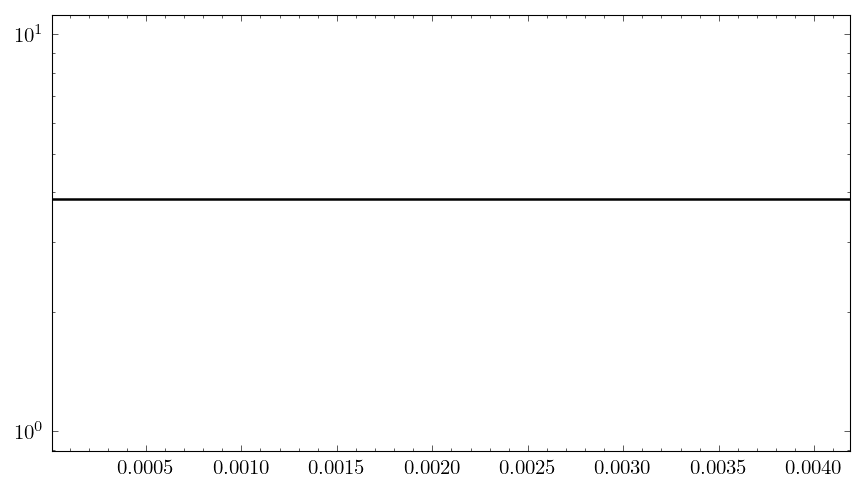

		determining the upper limit
		--->0.011485379008531058

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1099166839222505e-16
		--->'mle_theta_er': 0.5687152782841067
		--->'mle_theta_nr': 1.040003814916665
		defining the test statistic
		determining the upper limit
		--->0.004456339132285721

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.226563947415543e-17
		--->'mle_theta_er': 1.1282255408203983
		--->'mle_theta_nr': 1.0540332646464616
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4390: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


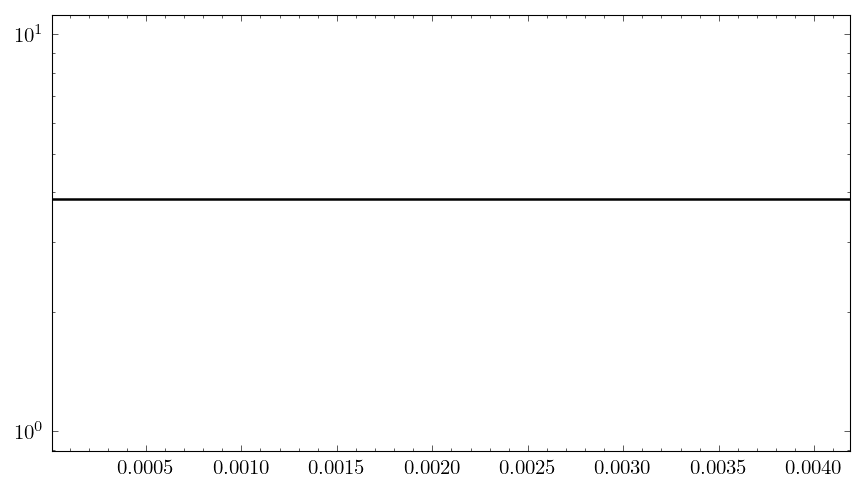

		determining the upper limit
		--->0.006572698517212768

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0289580443370722e-16
		--->'mle_theta_er': 0.7686793860147448
		--->'mle_theta_nr': 1.009672719448071
		defining the test statistic
		determining the upper limit
		--->0.004889046242481668

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.076287545847269e-17
		--->'mle_theta_er': 1.2822659787058837
		--->'mle_theta_nr': 1.075899746603822
		defining the test statistic
		determining the upper limit
		--->0.009690527625343845

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.326505932132359e-17
		--->'mle_theta_er': 0.9278474266534111
		--->'mle_theta_nr': 0.9641818392903156
		defining the test statistic
		determining the upper limit
		--->0.002253666

		--->0.00770425055452283

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.823305195463816e-17
		--->'mle_theta_er': 1.0626188120016806
		--->'mle_theta_nr': 1.0430748182254086
		defining the test statistic
		determining the upper limit
		--->0.007523252444848317

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.661971561847176e-17
		--->'mle_theta_er': 1.0640384634640572
		--->'mle_theta_nr': 1.0289562549729798
		defining the test statistic
		determining the upper limit
		--->0.006334887312220871

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.432007247700481e-17
		--->'mle_theta_er': 1.0223832917675626
		--->'mle_theta_nr': 0.9811481677829852
		defining the test statistic
		determining the upper limit
		--->0.0031717966431921915

		a priori calcula

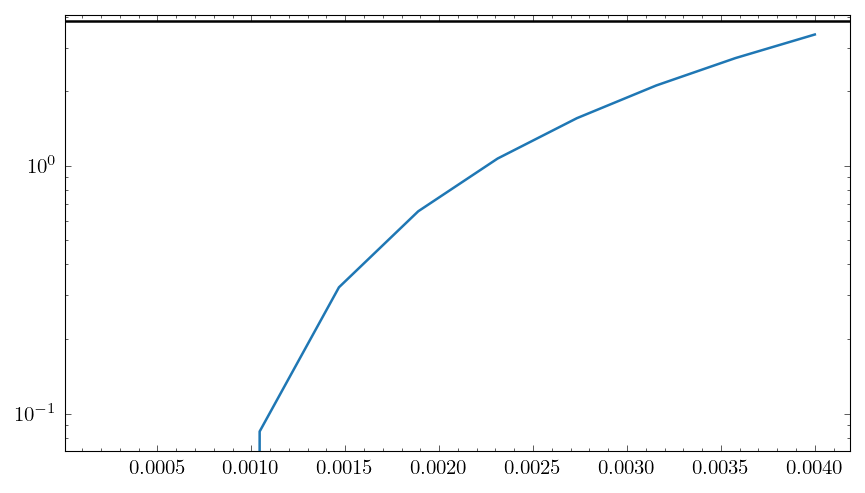

		determining the upper limit
		--->0.0042682823585684605
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 0.0042682823585684605
	determining the median upper limit (50 elements, different ones 50)
	'upper_limit_list' = [0.005057071457148504, 0.008547136756797021, 0.007902232312792922, 0.003089175522745581, 0.019616156010428838, 0.005329050470285236, 0.0032786165040515685, 0.0062386594721019015, 0.009095842769594631, 0.005973214519956627, 0.011689507568028284, 0.011485379008531058, 0.004456339132285721, 0.006572698517212768, 0.004889046242481668, 0.009690527625343845, 0.0022536667924956504, 0.022161792611110686, 0.004297530558577802, 0.004246528834001434, 0.010466235966919505, 0.012698533290772633, 0.021199045278296386, 0.010936690488901552, 0.0015512713705453749, 0.0034939735252741033, 0.014205516700899907, 0.005783486077700968, 0.017979565448823245, 0.011553192379684019, 

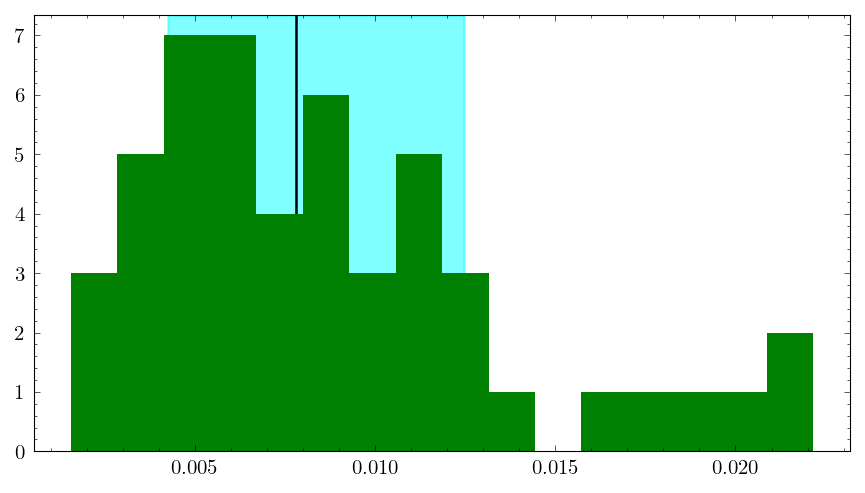

cwpec: filling the output dictionary
		finished within 5:57:21.749571 h'


In [19]:


if [False,True][1]:


    wimp_parameter_exclusion_curve_dict = sfs.calculate_wimp_parameter_exclusion_curve(
        # physical detector parameters
        detector__drift_field_v_cm                                       = darwin_baseline_detector_drift_field_v_cm,
        detector__nest_parameter_dict                                    = darwin_baseline_detector_dict,
        detector__runtime_y                                              = darwin_baseline_detector_runtime_y,
        detector__fiducial_mass_t                                        = darwin_baseline_detector_fiducial_mass_t,
        detector__detector_name                                          = "darwin_baseline_detector_sensitest",
        # physical spectrum parameters
        spectrum__default_spectrum_profiles                              = sfs.spectrum_dict_default_dict,
        spectrum__resources                                              = abspath_resources,
        spectrum__er_background_model                                    = "combined_er_background",
        spectrum__nr_background_model                                    = "combined_nr_background",
        spectrum__wimp_model                                             = "nr_wimps_wimprates",
        spectrum__er_background_rel_syst_flux_uncertainty                = 0.15,
        spectrum__nr_background_rel_syst_flux_uncertainty                = 0.15,
        # simulation setting
        simulation__er_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_er,
        simulation__nr_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_nr,
#        simulation__er_spectrum_energy_simulation_window_kev             = [1.0, 15.9],
#        simulation__nr_spectrum_energy_simulation_window_kev             = [3.5, 61.35],
        simulation__number_of_spectrum_energy_bins                       = default_simulation_energy_bins,
        simulation__number_of_upper_limit_simulations_per_wimp_mass      = 50,
        simulation__number_of_pdf_calculation_events                     = default_number_of_high_stat_simulations,
        simulation__number_of_samples_for_expectation_value_computation  = 200,
        # limit calculation parameters
        limit__er_eroi_kev                                               = default_wimp_eroi_kev_ee,
        limit__nr_eroi_kev                                               = default_wimp_eroi_kev_nr,
#        limit__er_eroi_kev                                               = [1.4, 10.6],
#        limit__nr_eroi_kev                                               = [4.9, 40.9],
        limit__wimp_mass_gev_list                                        = list(np.geomspace(start=10, stop=1000, num=10, endpoint=True)),
#        limit__wimp_mass_gev_list                                        = [10, 300],
        limit__number_of_cs1_bins                                        = 30, #40,
        limit__number_of_cs2_bins                                        = 25, #40,
        limit__cl                                                        = 0.9,
        # flags
        flag_verbose                                                     = [False, True, "high-level-only"][1],
        flag_plot_pdfs                                                   = [False, True, "er_nr_only"][1],
        flag_plot_test_statistics                                        = [False, True, 0.1][2],
        flag_plot_upper_limit_root_finding                               = [False, True, 0.1][2],
        flag_plot_upper_limit_distribution                               = [False, True, 0.1][1],
        flag_load_er_and_nr_signatures_for_pdf_calculation               = [False,True][1],
    )

    datestring = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    sfs.write_dict_to_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict" +"__" +datestring +".json", wimp_parameter_exclusion_curve_dict)

    # printing test output
    #print(f"\n\ntest output:")
    #print(f"\n'cs1_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs1_bin_edges']}")
    #print(f"\n'cs2_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs2_bin_edges']}")
    #for spectrum_string in ["er_background", "nr_background", "wimps"]:
    #    print(f"\n{spectrum_string}")
    #    print(f"'spectral_pdf': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['spectral_pdf']}")
    #    print(f"'number_of_expected_events_within_eroi': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['number_of_expected_events_within_eroi']}")



With 20 WIMP masses and 'sims_per_wimp_mass'=200 the code above took ~11.5h to run.


[50.0, 223.60679774997897, 1000.0]
[0.00032604838579840755, 0.0007954986623878507, 0.007803241433657876]
[0.00012180549842631589, 0.000491332096419206, 0.004246528834001434]
[0.0006182736471005393, 0.001483538229202286, 0.012452257125283151]


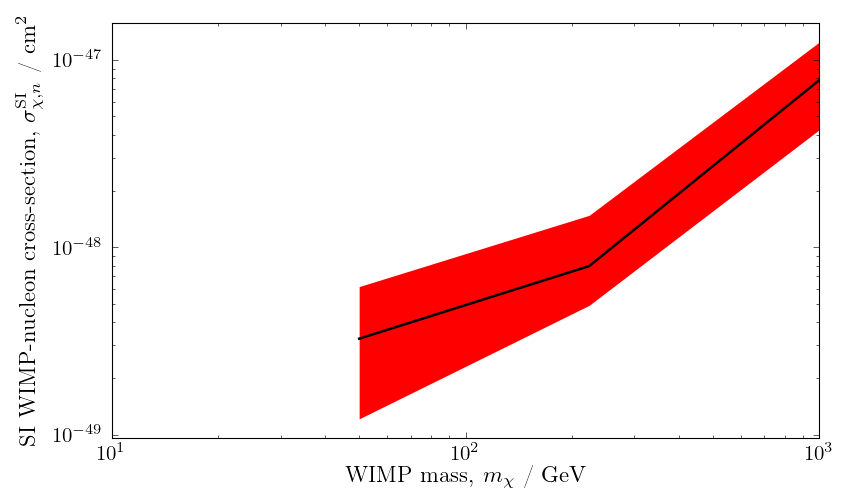

In [23]:


if [False,True][1]:

    #wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict" +"__" +datestring +".json")
    #wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict__20230424_0507.json") # 6:38h
    #wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict__20230601_1813.json") # 6:38h
    #wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict__20230602_2110.json") # 6:38h
    #wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict__20230603_1736.json") # 6:38h
    wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict__20230604_0059.json") # 6:38h

    sfs.plot_sensitivity_curve_comparison(
        sensitivity_curve_dict_list   = [wimp_parameter_exclusion_curve_dict_loaded],
        flag_comp_values              = [],#np.geomspace(start=2.3, stop=4.7, num=4, endpoint=True),
        cbar_label                    = r"drift field strength, $E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$",
        legend_colors                 = ["red"],
        plot_logxscale                = True,
        plot_logyscale                = True,
        output_abspath_list           = [path+ "test__plot_sensitivity_curve_comparison.png" for path in abspath_list_plots],
    )




<br>
<br>


# Study: Test NEST Output for Repetitions


<br>
<br>



In [21]:

if [False,True][0]:
    
    
    # definitions
    test_seed_default = 1
    energy_list = [1.0, 2.0, 3.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0]
    n_test_datasets = len(energy_list)
    number_of_events_per_energy = 1000
    test_seed_random_list = [randrange(10000001) for k in range(n_test_datasets)]
    
    # running NEST
    print(f"running NEST")
    if [False,True][1]:
        nest_test_data_list = []
        for k in range(n_test_datasets):
            seed = randrange(10000001)
#            nest_test_spectrum_dict = {
#                    "seed": test_seed_random_list[k],
#                    "field_drift[V/cm]": "200",
#                    "x,y,z-position[mm]": "-1",
#                    "numEvts": [number_of_events_per_energy for j in range(len(energy_list))],
#                    "type_interaction": "ER",
#                    "E_min[keV]": energy_list,
#                    "E_max[keV]": energy_list,
#                }
            nest_test_spectrum_dict = {
                    "seed": seed,
                    "field_drift[V/cm]": "200",
                    "x,y,z-position[mm]": "-1",
                    "numEvts": [number_of_events_per_energy],
                    "type_interaction": "ER",
                    "E_min[keV]": [energy_list[k]],
                    "E_max[keV]": [energy_list[k]],
                }
            print(f"\tNEST run {k} of {n_test_datasets-1}")
            print(f"\t\trandom seed: {seed}")
            nest_test_ndarray = sfs.execNEST(
                spectrum_dict = nest_test_spectrum_dict,
                baseline_detector_dict = darwin_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                detector_dict = darwin_baseline_detector_dict,
                detector_name = "example__detector__darwin_baseline_detector",
                abspath_list_detector_dict_json_output = [abspath_detectors],
                flag_verbose = False,
                flag_print_stdout_and_stderr = False,)
            nest_test_data_list.append(nest_test_ndarray)

    
    # test 1: does the output contain duplicates
    print(f"test 1: does the output contain duplicates")
    for k, nest_test_ndarray in enumerate(nest_test_data_list):
        print(f"\texamining dataset {k} of {n_test_datasets-1} individually")
        for column in ["S1 [PE or phe]", "S2_3Dcorr [phd]"]:
            length_list = len(list(nest_test_ndarray[column]))
            length_set = len(set(list(nest_test_ndarray[column])))
            print(f"\t\t'column': {column}")
            print(f"\t\t'length_list': {length_list}")
            print(f"\t\t'length_set': {length_set}")
    print(f"\tcomparing all datasets against each other")
    for column in ["S1 [PE or phe]", "S2_3Dcorr [phd]"]:
        combined_data_list = [list(nest_test_ndarray[column]) for k, nest_test_ndarray in enumerate(nest_test_data_list)]
        combined_data_list = sum(combined_data_list, [])
        combined_data_set = set(combined_data_list)
        print(f"\t\t'column': {column}")
        print(f"\t\t'length_list': {len(combined_data_list)}")
        print(f"\t\t'length_set': {len(combined_data_set)}")
            
        
    
    
    
    


<br>
<br>


# Study: How Does S2/S1 Change with Energy?


<br>
<br>



In [22]:


#test_ndarray = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy")
#print(test_ndarray.dtype.names)
# NEST ndarray column names:
# 'E_truth [keV]'
# 'field [V/cm]'
# 'tDrift [us]'
# 'X,Y,Z [mm]'
# 'Nph'
# 'Ne-'
# 'S1 [PE or phe]'
# 'S1_3Dcor [phd]'
# 'spikeC(NON-INT)'
# 'Ne-Extr'
# 'S2_rawArea [PE]'
# 'S2_3Dcorr [phd]'
abspath_test = abspath_study +"test/"

if [False,True][0]:
    import matplotlib.gridspec as gridspec


    # definitions
    print(f"definitions")
    test_seed_default = 1
    e_drift_v_cm = 10
    energy_list_kev = np.linspace(start=5.0, stop=100, num=20, endpoint=True)
    print(f"'energy_list_kev' = {energy_list_kev}")
    #energy_list_kev = [5.0, 15.0, 40.0]
    number_of_events_per_energy = 1000
    nest_data_sets = []


    # data generation
    print(f"data generation")
    for it in ["ER", "NR"]:
        for i, e_kev in enumerate(energy_list_kev):
            run_id = f"{it}__{str(int(e_kev))}"
            print(f"\trun_id: {run_id}")
            # defining spectra dicts
            print(f"\t\tdefining spectrum dict")
            nest_spectrum_dict = {
                "seed": test_seed_default,
                "field_drift[V/cm]": str(e_drift_v_cm),
                "x,y,z-position[mm]": "-1",
                "numEvts": [number_of_events_per_energy],
                "type_interaction": it,
                "E_min[keV]": [e_kev],
                "E_max[keV]": [e_kev],
            }
            # running NEST
            if [False,True][0]:
                print(f"\t\trunning NEST")
                nest_ndarray = sfs.execNEST(
                    spectrum_dict = nest_spectrum_dict,
                    baseline_detector_dict = darwin_baseline_detector_dict,
                    baseline_drift_field_v_cm = e_drift_v_cm,
                    detector_dict = darwin_baseline_detector_dict,
                    detector_name = "example__detector__darwin_baseline_detector",
                    abspath_list_detector_dict_json_output = [abspath_detectors],
                    flag_verbose = False,
                    flag_print_stdout_and_stderr = False,)
                print(f"\t\tsaving NEST data")
                np.save(abspath_test +run_id +".npy", nest_ndarray)
                print(f"\t\tsaved '{abspath_test +run_id +'.npy'}'")
            else:
                print(f"\t\tnot running NEST")
            nest_data_sets.append(run_id)
            # saving NEST data


    # data generation
    print(f"plotting")
    # setting up canvas and axes
    print(f"\tsetting up canvas and axes")
    fig = plt.figure(figsize=[5.670, 5.670*9/16], constrained_layout=False, dpi=150)
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.10, 0.88, 0.02],
        height_ratios = [0.005, 0.875, 0.12],)
    ax = fig.add_subplot(spec[1, 1])
    ax.set_xlabel(r"recoil energy, $E\,/\,\mathrm{keV}$", labelpad=2)
    ax.set_ylabel(r"charge-to-light ratio, $\frac{S_2}{S_1}\,/\,\%$", labelpad=2)
    # plotting
    print(f"\tplotting")
    for run_id in [*nest_data_sets]:
        nest_dataset = np.load(abspath_test +run_id +".npy")
        print(f"\t\tdata generation")
        it = str(list(run_id.split("__"))[0])
        e_kev = float(list(run_id.split("__"))[1])
        plot_data_y = [event['Ne-']/event['Nph'] for j, event in enumerate(nest_dataset)]
        plto_data_y_err = [np.std(plot_data_y)]
        plot_data_y = [np.mean(plot_data_y)]
        plot_data_x = [e_kev for entry in plot_data_y]
        plot_data_x = [e_kev]
        print(f"\t\tinteraction type: {it}")
        print(f"\t\tenergy: {e_kev} keV")
        print(f"\t\tplot_data_y: {plot_data_y}")
        print(f"\t\tplot_data_x: {plot_data_x}")
        ax.errorbar(
            marker = "o",
            markersize = 3.8,
            markerfacecolor = "white",
            markeredgewidth = 0.5,
            markeredgecolor = "red" if it=="ER" else "blue",
            ecolor = "red" if it=="ER" else "blue",
            elinewidth = 0.5,
            capsize = 1.2,
            barsabove = True,
            capthick = 0.5,
            linestyle = "",
            fmt = '',
            x = plot_data_x,
            y = plot_data_y,
            yerr = plto_data_y_err,
        )
    plt.show()
        
    
    
    
    